# GBP/USD – Pipeline Algorithmique M1 → M15
## T01 · T02 · T03 · T04 · T05 · T06 · T07

---

# T01 : Import M1 & Contrôle de Régularité

## 1. Contexte et Objectifs

Dans le cadre du projet de trading algorithmique sur la paire GBP/USD, cette première étape consiste à importer et valider les données brutes à la minute (M1) sur la période 2022-2025.

Les objectifs spécifiques à cette tâche (T01) sont :
1. **Importation** : Charger les fichiers CSV bruts pour les années 2022, 2023, 2024 et 2025.
2. **Prétraitement** : Convertir les colonnes de date et d'heure en un index `datetime` exploitable.
3. **Audit de Qualité** : Identifier les valeurs manquantes, les doublons et les ruptures de séquence (gaps).
4. **Analyse Descriptive** : Visualiser les distributions de prix et de volumes pour détecter d'éventuelles anomalies.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display  # FIX : import display manquant dans tout le notebook


sns.set_theme(style="darkgrid")  

plt.rcParams.update({
    "figure.facecolor":  "#1E1E1E",   # gris très foncé
    "axes.facecolor":    "#1C1C1C",   # fond axes sombre
    "grid.color":        "#444444",   # grille discrète
    "grid.linestyle":    "--",
    "grid.linewidth":    0.5,
    "text.color":        "#F5F5F5",
    "axes.labelcolor":   "#F5F5F5",
    "xtick.color":       "#F5F5F5",
    "ytick.color":       "#F5F5F5",
    "axes.titlecolor":   "#F5F5F5",
    "axes.prop_cycle":   plt.cycler(color=['#00FF00', '#FF0000', '#00BFFF', '#FFD700'])  # vert=up, rouge=down, bleu, or
})
plt.rcParams.update({
    "axes.edgecolor": "#888888",  # axes gris clair
    "axes.linewidth": 1,
    "figure.autolayout": True,
})

# Constantes
DATA_DIR = "data"
FILES = {
    "2022": "DAT_MT_GBPUSD_M1_2022.csv",
    "2023": "DAT_MT_GBPUSD_M1_2023.csv",
    "2024": "DAT_MT_GBPUSD_M1_2024.csv",
    "2025": "DAT_MT_GBPUSD_M1_2025.csv",
}
COLUMNS = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']

## 2. Importation des Données

In [105]:
def load_data(year, filename):
    """Charge, convertit et indexe les données M1 d'une année donnée."""
    path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(path):
        print(f"[ERREUR] Fichier introuvable : {path}")
        return None

    print(f"[{year}] Chargement de {filename}...")
    df = pd.read_csv(path, names=COLUMNS, header=None)

    # Format attendu : 'YYYY.MM.DD HH:MM'
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'],
                                    format='%Y.%m.%d %H:%M')
    df.drop(columns=['date', 'time'], inplace=True)
    df.set_index('datetime', inplace=True)

    print(f"[{year}] Chargé avec succès. Dimensions : {df.shape}")
    return df

dfs = {}
for year, fname in FILES.items():
    df_res = load_data(year, fname)
    if df_res is not None:
        dfs[year] = df_res

[2022] Chargement de DAT_MT_GBPUSD_M1_2022.csv...
[2022] Chargé avec succès. Dimensions : (372494, 5)
[2023] Chargement de DAT_MT_GBPUSD_M1_2023.csv...
[2023] Chargé avec succès. Dimensions : (322467, 5)
[2024] Chargement de DAT_MT_GBPUSD_M1_2024.csv...
[2024] Chargé avec succès. Dimensions : (372107, 5)
[2025] Chargement de DAT_MT_GBPUSD_M1_2025.csv...
[2025] Chargé avec succès. Dimensions : (371091, 5)


In [106]:
for year, df in dfs.items():
    print(f"\n===== {year} =====")
    print(df.head(5))



===== 2022 =====
                        open     high      low    close  volume
datetime                                                       
2022-01-02 17:01:00  1.35199  1.35213  1.35199  1.35213       0
2022-01-02 17:02:00  1.35232  1.35232  1.35232  1.35232       0
2022-01-02 17:04:00  1.35233  1.35233  1.35233  1.35233       0
2022-01-02 17:06:00  1.35233  1.35233  1.35233  1.35233       0
2022-01-02 17:10:00  1.35233  1.35233  1.35233  1.35233       0

===== 2023 =====
                        open     high      low    close  volume
datetime                                                       
2023-01-01 18:04:00  1.20615  1.20615  1.20613  1.20613       0
2023-01-01 18:05:00  1.20494  1.20615  1.20494  1.20590       0
2023-01-01 18:06:00  1.20497  1.20497  1.20497  1.20497       0
2023-01-01 18:07:00  1.20668  1.20668  1.20664  1.20664       0
2023-01-01 18:08:00  1.20564  1.20664  1.20564  1.20664       0

===== 2024 =====
                        open     high      low    

## 3. Contrôle de la Qualité des Données

Vérification selon trois critères :
1. **Intégrité** : Présence de valeurs manquantes (NaN).
2. **Unicité** : Détection de doublons temporels.
3. **Continuité** : Détection des interruptions de cotation (Gaps).

In [107]:
def audit_quality(df, year):
    """Réalise un audit technique du DataFrame."""
    print(f"\n--- Audit Qualité {year} ---")

    nan_count   = df.isna().sum().sum()
    duplicates  = df.index.duplicated().sum()
    print(f"Valeurs NaN totales : {nan_count}")
    print(f"Index dupliqués     : {duplicates}")

    deltas       = df.index.to_series().diff()
    gaps         = deltas[deltas > pd.Timedelta(minutes=1)]
    weekend_gaps = gaps[gaps > pd.Timedelta(hours=48)]
    other_gaps   = gaps[(gaps > pd.Timedelta(minutes=5)) & (gaps <= pd.Timedelta(hours=48))]

    print(f"Total discontinuités (> 1 min)           : {len(gaps)}")
    print(f"Dont Week-ends probables (> 48h)          : {len(weekend_gaps)}")
    print(f"Gaps anormaux intrasemaine (> 5 min)       : {len(other_gaps)}")

    if len(other_gaps) > 0:
        print("Exemples de gaps anormaux :")
        print(other_gaps.head(3))

    return duplicates

total_dupes = 0
for year, df in dfs.items():
    total_dupes += audit_quality(df, year)


--- Audit Qualité 2022 ---
Valeurs NaN totales : 0
Index dupliqués     : 60
Total discontinuités (> 1 min)           : 1109
Dont Week-ends probables (> 48h)          : 49
Gaps anormaux intrasemaine (> 5 min)       : 43
Exemples de gaps anormaux :
datetime
2022-01-04 17:20:00   0 days 00:06:00
2022-01-09 17:10:00   0 days 00:07:00
2022-01-13 17:28:00   0 days 00:08:00
Name: datetime, dtype: timedelta64[ns]

--- Audit Qualité 2023 ---
Valeurs NaN totales : 0
Index dupliqués     : 60
Total discontinuités (> 1 min)           : 1407
Dont Week-ends probables (> 48h)          : 50
Gaps anormaux intrasemaine (> 5 min)       : 695
Exemples de gaps anormaux :
datetime
2023-01-01 18:18:00   0 days 00:10:00
2023-01-16 17:30:00   0 days 00:06:00
2023-02-07 18:00:00   0 days 01:01:00
Name: datetime, dtype: timedelta64[ns]

--- Audit Qualité 2024 ---
Valeurs NaN totales : 0
Index dupliqués     : 60
Total discontinuités (> 1 min)           : 1666
Dont Week-ends probables (> 48h)          : 50
Gaps an

### Correction des Doublons

In [108]:
if total_dupes > 0:
    print("\n--- Correction des Doublons ---")
    for year, df in dfs.items():
        init_len  = len(df)
        dfs[year] = df[~df.index.duplicated(keep='first')]
        diff      = init_len - len(dfs[year])
        if diff > 0:
            print(f"[{year}] {diff} doublons supprimés.")
else:
    print("Aucun doublon à corriger.")


--- Correction des Doublons ---
[2022] 60 doublons supprimés.
[2023] 60 doublons supprimés.
[2024] 60 doublons supprimés.
[2025] 60 doublons supprimés.


## 4. Analyse Exploratoire Visuelle

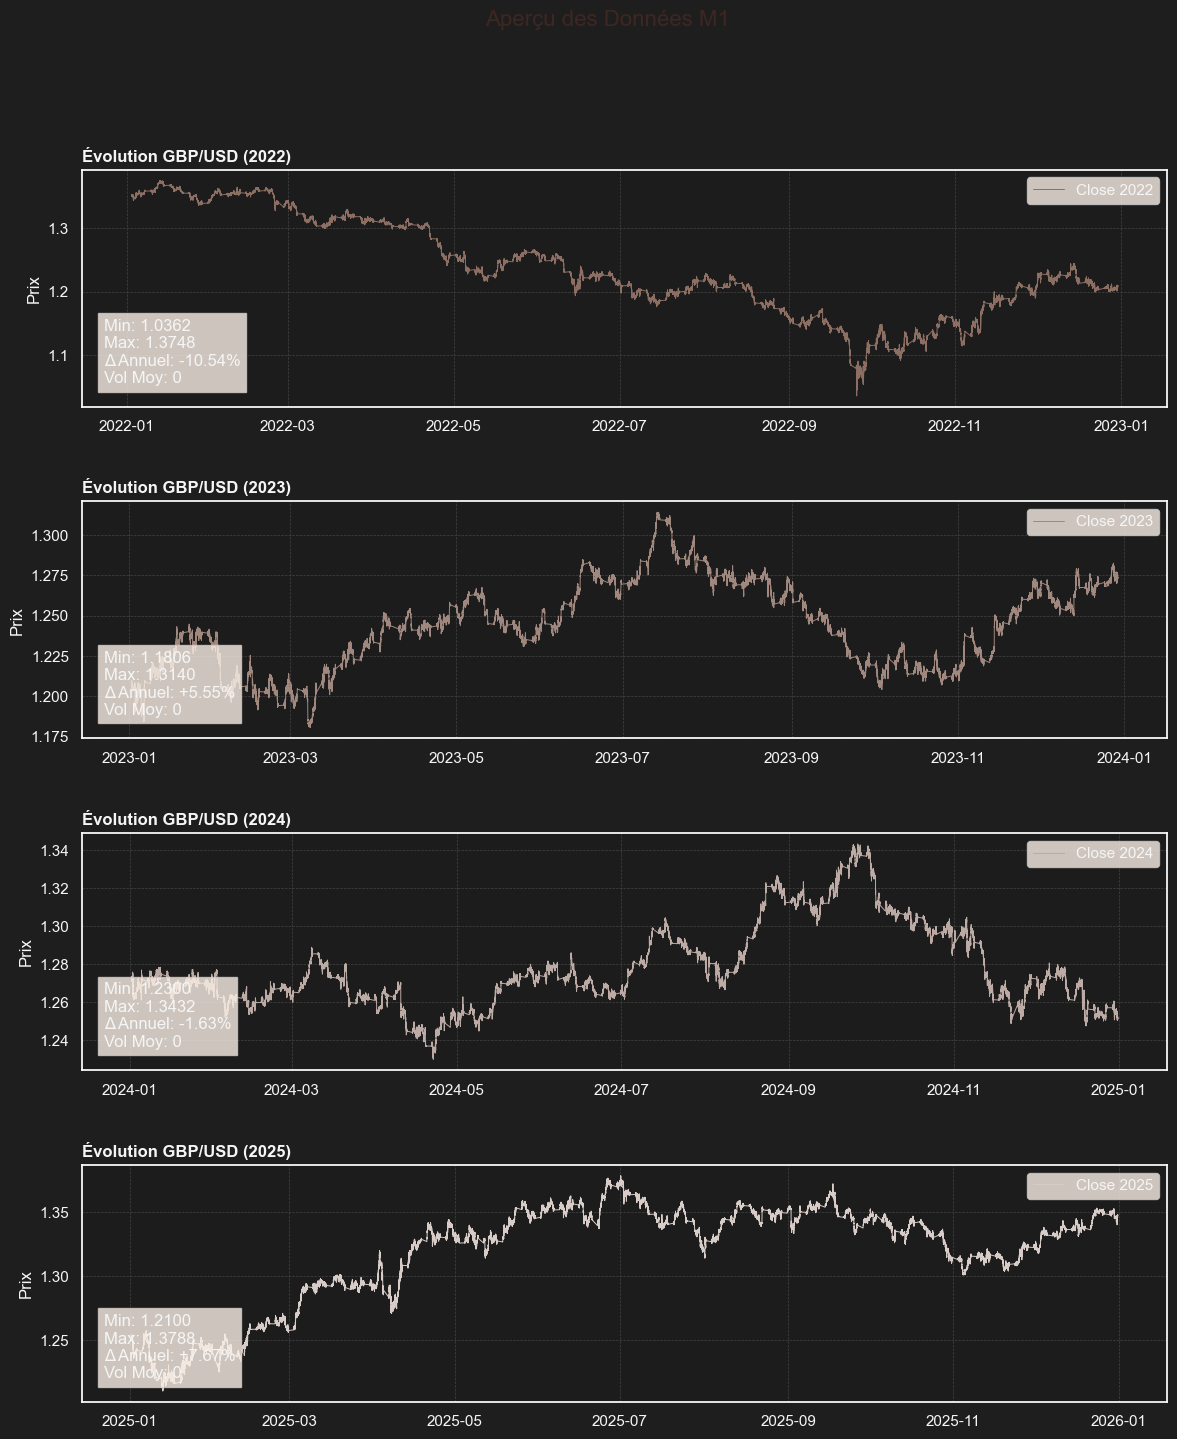

In [109]:
# FIX : on limite le subplot aux années effectivement chargées
years_loaded = list(dfs.keys())
n_years      = len(years_loaded)
colors       = ['#8D6E63', '#A1887F', '#BCAAA4', '#D7CCC8'][:n_years]

fig, axes = plt.subplots(n_years, 1, figsize=(14, 4 * n_years), sharex=False)
if n_years == 1:
    axes = [axes]
plt.subplots_adjust(hspace=0.4)

for i, year in enumerate(years_loaded):
    df  = dfs[year]
    ax  = axes[i]
    ax.plot(df.index, df['close'], color=colors[i], linewidth=0.7, label=f'Close {year}')
    ax.set_title(f"Évolution GBP/USD ({year})", loc='left', fontsize=12, fontweight='bold')
    ax.set_ylabel("Prix")
    ax.legend(loc='upper right', frameon=True, facecolor='#FAF0E6')
    start_price = df['close'].iloc[0]
    end_price   = df['close'].iloc[-1]
    annual_var  = (end_price / start_price - 1) * 100
    stats_str = (f"Min: {df['close'].min():.4f}\n"
                 f"Max: {df['close'].max():.4f}\n"
                 f"Δ Annuel: {annual_var:+.2f}%\n"
                 f"Vol Moy: {int(df['volume'].mean())}")
    ax.text(0.02, 0.1, stats_str, transform=ax.transAxes,
            bbox=dict(facecolor='#FAF0E6', alpha=0.8, edgecolor='#D7CCC8'))

plt.suptitle("Aperçu des Données M1", fontsize=16, y=0.98, color='#3E2723')
plt.show()

C:\Users\JC\AppData\Local\Temp\ipykernel_29352\1518259372.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(dfs[year]['volume'], label=year, fill=True,
C:\Users\JC\AppData\Local\Temp\ipykernel_29352\1518259372.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(dfs[year]['volume'], label=year, fill=True,
C:\Users\JC\AppData\Local\Temp\ipykernel_29352\1518259372.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(dfs[year]['volume'], label=year, fill=True,
C:\Users\JC\AppData\Local\Temp\ipykernel_29352\1518259372.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(dfs[year]['volume'], label=year, fill=True,
C:\Users\JC\AppData\Local\Temp\ipykernel_29352\1

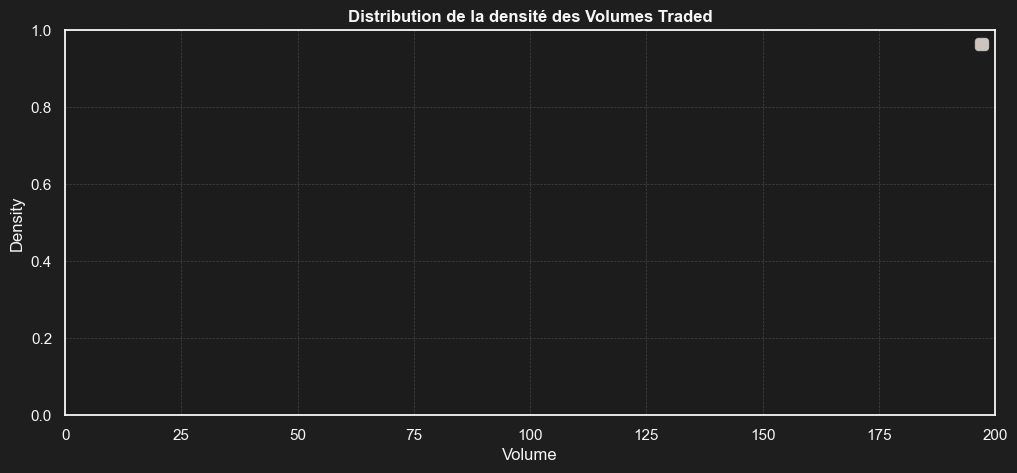

In [110]:
plt.figure(figsize=(12, 5))
for i, year in enumerate(years_loaded):
    sns.kdeplot(dfs[year]['volume'], label=year, fill=True,
                color=colors[i], alpha=0.3)

plt.title("Distribution de la densité des Volumes Traded", fontsize=12, fontweight='bold')
plt.xlabel("Volume")
plt.xlim(0, 200)
plt.legend(facecolor='#FAF0E6')
plt.show()

In [111]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_gaps_timeline(df, year):
    deltas = df.index.to_series().diff()
    gaps = deltas[deltas > pd.Timedelta(minutes=1)]

    if gaps.empty:
        print(f"Aucun gap détecté pour {year}")
        return

    gap_times = gaps.index
    gap_sizes = gaps.dt.total_seconds() / 60  # minutes

    plt.figure(figsize=(12, 4))
    plt.scatter(gap_times, gap_sizes)
    plt.title(f"Gaps temporels détectés – {year}")
    plt.xlabel("Temps")
    plt.ylabel("Durée du gap (minutes)")
    plt.tight_layout()
    plt.show()


In [112]:
def plot_gap_distribution(df, year):
    deltas = df.index.to_series().diff()
    gaps = deltas[deltas > pd.Timedelta(minutes=1)]

    if gaps.empty:
        return

    gap_minutes = gaps.dt.total_seconds() / 60

    plt.figure(figsize=(6, 4))
    plt.hist(gap_minutes, bins=50)
    plt.title(f"Distribution des gaps – {year}")
    plt.xlabel("Durée du gap (minutes)")
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()


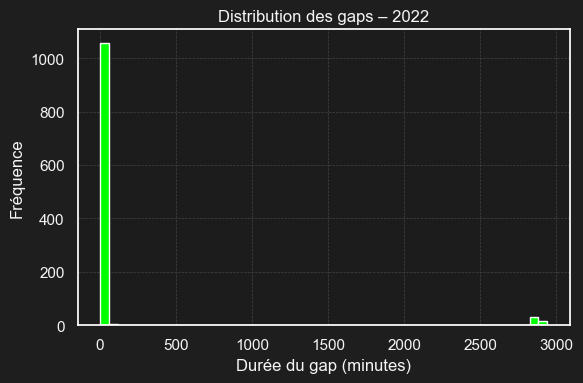

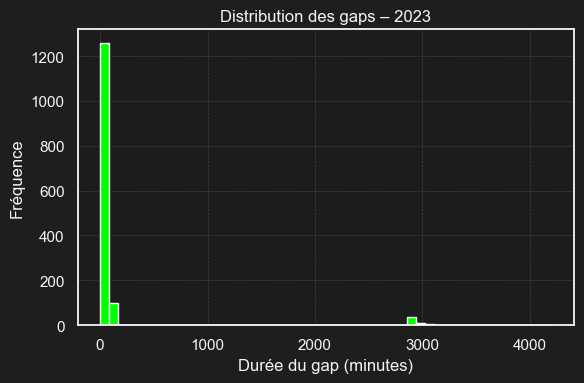

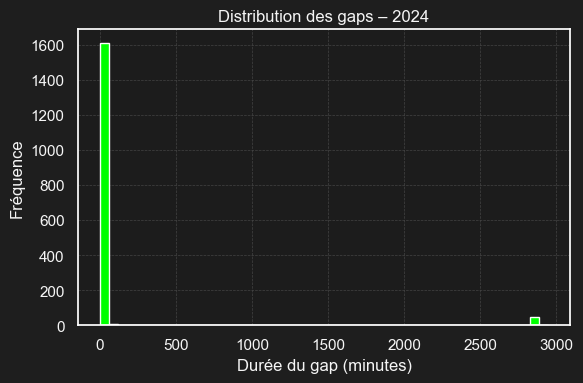

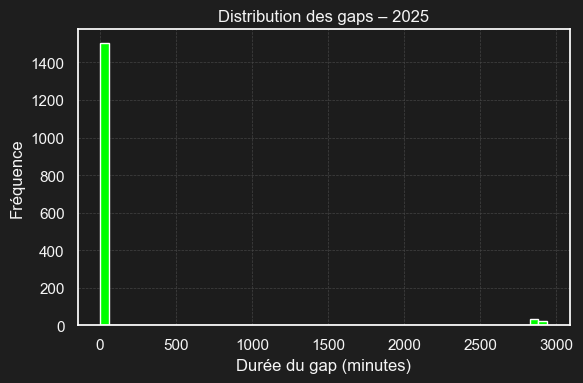

In [113]:
for year, df in dfs.items():
    plot_gap_distribution(df, year)


In [114]:
def plot_gap_by_day(df, year):
    deltas = df.index.to_series().diff()
    gaps = deltas[deltas > pd.Timedelta(minutes=1)]

    if gaps.empty:
        return

    gaps_by_day = gaps.groupby(gaps.index.date).count()

    plt.figure(figsize=(12, 3))
    gaps_by_day.plot(kind="bar")
    plt.title(f"Nombre de gaps par jour – {year}")
    plt.xlabel("Jour")
    plt.ylabel("Nombre de gaps")
    plt.tight_layout()
    plt.show()


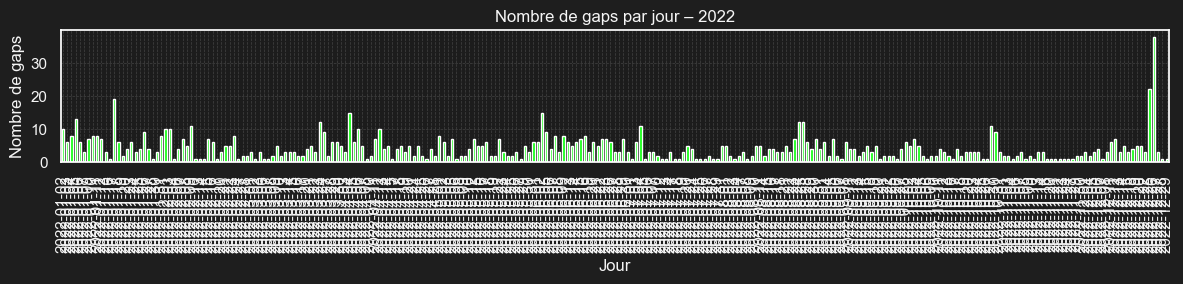

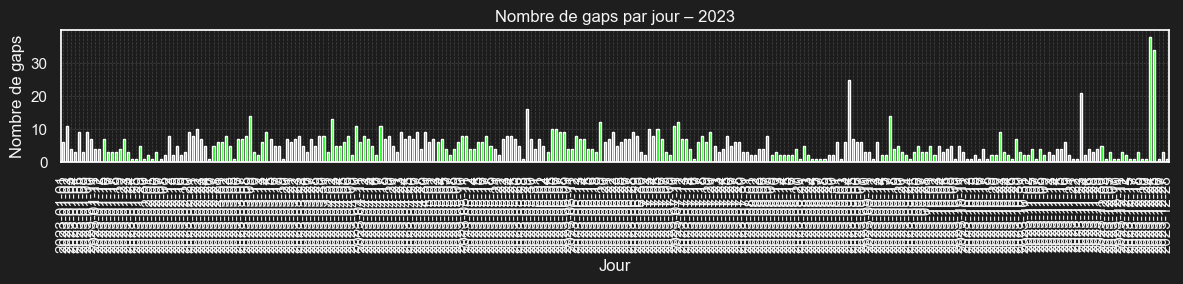

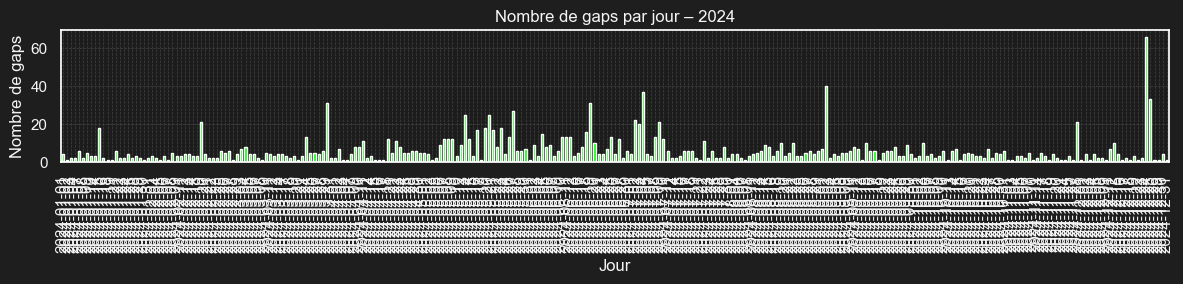

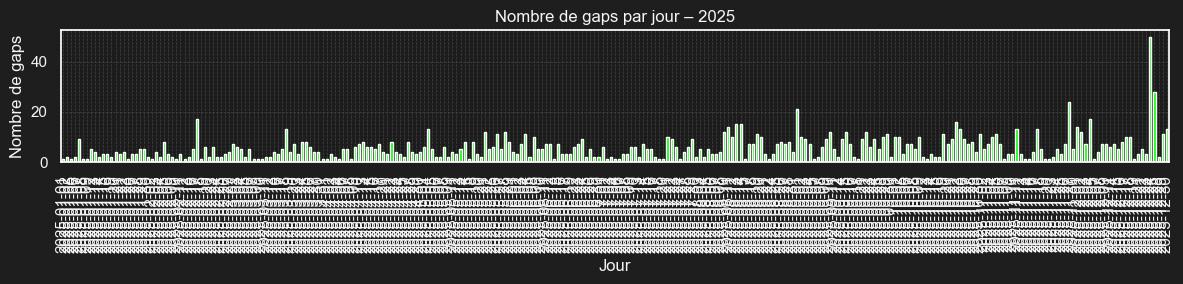

In [115]:
for year, df in dfs.items():
    plot_gap_by_day(df, year)

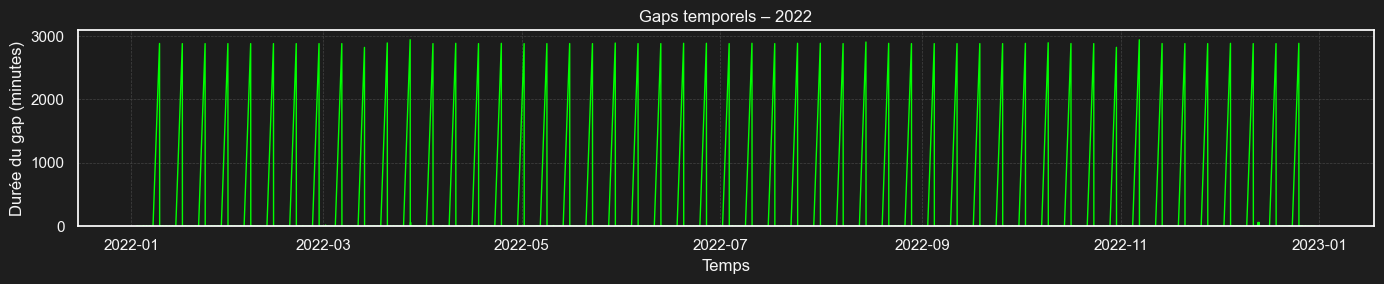

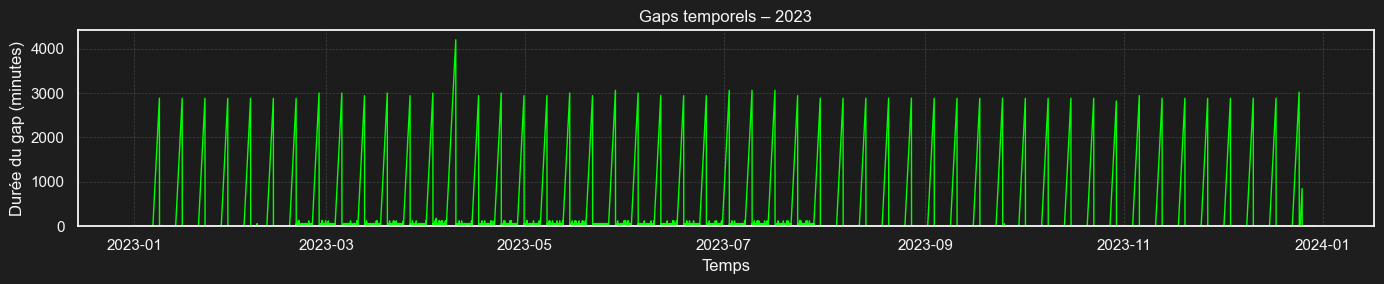

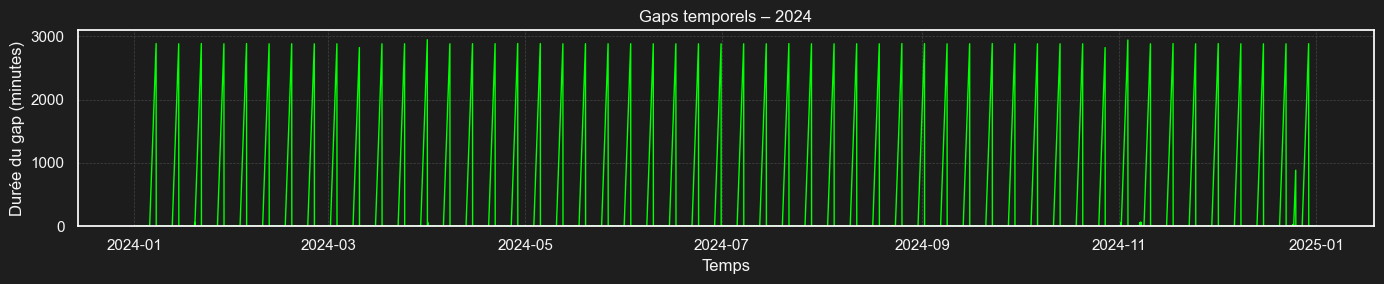

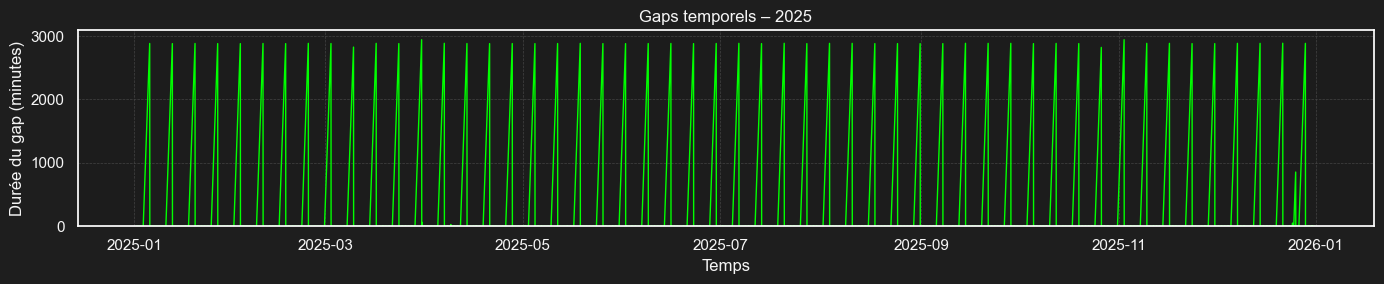

In [116]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_annual_gap_curve(df, year):
    # Calcul des deltas temporels
    deltas = df.index.to_series().diff()

    # Initialisation d'une série nulle
    gap_curve = pd.Series(
        data=0.0,
        index=df.index
    )

    # Détection des gaps (> 1 minute)
    gaps = deltas[deltas > pd.Timedelta(minutes=1)]

    # Injection des durées de gaps (en minutes)
    gap_curve.loc[gaps.index] = gaps.dt.total_seconds() / 60

    # Plot
    plt.figure(figsize=(14, 3))
    plt.plot(gap_curve.index, gap_curve.values, linewidth=1)
    plt.title(f"Gaps temporels – {year}")
    plt.xlabel("Temps")
    plt.ylabel("Durée du gap (minutes)")
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()
for year, df in dfs.items():
    plot_annual_gap_curve(df, year)


## 5. Bilan et Validation T01

**Synthèse de l'audit** :
1. **Validité structurelle** : Les fichiers CSV sont conformes au format MT4/MT5.
2. **Nettoyage** : Les doublons temporels ont été identifiés et traités.
3. **Continuité** : Les gaps reflètent majoritairement les fermetures de marché (week-ends).

**Décision** : Dataset **VALIDE** pour T02.

---

# T02 : Agrégation M1 → M15

## 1. Objectif
Transformer les données brutes **1 minute** en bougies **15 minutes** :
- `open_15m`  = open de la **1ère minute** du bloc
- `high_15m`  = **max(high)** sur 15 minutes
- `low_15m`   = **min(low)** sur 15 minutes
- `close_15m` = close de la **dernière minute** du bloc
- `volume`    = sum(volume) sur 15 minutes
- `tick_count`= nombre de minutes M1 présentes dans le bloc

In [117]:
# FIX : plt.style.use('seaborn-v0_8-darkgrid') est déprécié selon la version matplotlib.
#        On utilise sns.set_theme() déjà appliqué en T01.
#        On réimporte scipy/statsmodels ici pour la section T04 qui suit.
from scipy import stats as sp_stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path
import sys

# Palette commune T02–T04
YEARS  = [2022, 2023, 2024, 2025]
LABELS = {2022: '🟦 Train', 2023: '🟦 Train', 2024: '🟧 Validation', 2025: '🟩 Test'}
COLORS = {2022: 'steelblue', 2023: 'blue', 2024: 'darkorange', 2025: 'green'}

print("Imports T02-T05 OK")

Imports T02-T05 OK


## 2. Aperçu des données brutes M1

In [118]:
test = Path(
    r"C:\Users\JC\Documents\Sup_de_vinci\M2\Datascience\Projet_final\data\DAT_MT_GBPUSD_M1_2025.csv"
)

print(test.exists())


True


In [119]:
# Chemins M1 – adaptez PROJECT_ROOT à votre arborescence
PROJECT_ROOT = Path('.').resolve()

m1_files = {
    2022: PROJECT_ROOT / 'data' / 'DAT_MT_GBPUSD_M1_2022.csv',
    2023: PROJECT_ROOT / 'data' / 'DAT_MT_GBPUSD_M1_2023.csv',
    2024: PROJECT_ROOT / 'data' / 'DAT_MT_GBPUSD_M1_2024.csv',
    2025: PROJECT_ROOT / 'data' / 'DAT_MT_GBPUSD_M1_2025.csv'
}
cols_m1 = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']

for year, path in m1_files.items():
    if not path.exists():
        print(f"[SKIP] {path} introuvable")
        continue
    df_m1 = pd.read_csv(path, header=None, names=cols_m1)
    print(f'\n📅 {year} ({LABELS[year]}) : {len(df_m1):,} lignes M1')
    print(f'   Période : {df_m1["date"].iloc[0]} → {df_m1["date"].iloc[-1]}')
    display(df_m1.head(3))


📅 2022 (🟦 Train) : 372,494 lignes M1
   Période : 2022.01.02 → 2022.12.30


,date,time,open,high,low,close,volume
0,2022.01.02,17:01,1.35199,1.35213,1.35199,1.35213,0
1,2022.01.02,17:02,1.35232,1.35232,1.35232,1.35232,0
2,2022.01.02,17:04,1.35233,1.35233,1.35233,1.35233,0



📅 2023 (🟦 Train) : 322,467 lignes M1
   Période : 2023.01.01 → 2023.12.29


,date,time,open,high,low,close,volume
0,2023.01.01,18:04,1.20615,1.20615,1.20613,1.20613,0
1,2023.01.01,18:05,1.20494,1.20615,1.20494,1.20590,0
2,2023.01.01,18:06,1.20497,1.20497,1.20497,1.20497,0



📅 2024 (🟧 Validation) : 372,107 lignes M1
   Période : 2024.01.01 → 2024.12.31


,date,time,open,high,low,close,volume
0,2024.01.01,17:00,1.27184,1.27184,1.27184,1.27184,0
1,2024.01.01,17:04,1.27155,1.27208,1.27155,1.27208,0
2,2024.01.01,17:05,1.27207,1.27211,1.27207,1.27211,0



📅 2025 (🟩 Test) : 371,091 lignes M1
   Période : 2025.01.01 → 2025.12.31


,date,time,open,high,low,close,volume
0,2025.01.01,17:01,1.25134,1.25138,1.25134,1.25138,0
1,2025.01.01,17:02,1.25136,1.25136,1.25136,1.25136,0
2,2025.01.01,17:04,1.25136,1.25136,1.25113,1.25113,0


### Agrégation M15

In [120]:
def load_and_clean_m1(path):
    cols = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']
    df = pd.read_csv(path, header=None, names=cols)

    # Construction du timestamp
    df['timestamp'] = pd.to_datetime(
        df['date'] + ' ' + df['time'],
        format='%Y.%m.%d %H:%M'
    )

    df = (
        df
        .set_index('timestamp')
        .sort_index()
    )

    # Suppression des doublons M1 (clé = timestamp)
    df = df[~df.index.duplicated(keep='first')]

    return df

def m1_to_m15(df_m1):
    grouped = df_m1.resample('15T')

    m15 = grouped.agg(
        open_15m  = ('open',  'first'),
        high_15m  = ('high',  'max'),
        low_15m   = ('low',   'min'),
        close_15m = ('close', 'last'),
        volume    = ('volume','sum'),
        tick_count= ('close', 'count')
    )

    # 🔥 Suppression des bougies M15 incomplètes
    m15 = m15[m15['tick_count'] == 15]

    return m15


In [121]:
m15 = {}

for year, path in m1_files.items():
    if not path.exists():
        print(f"[SKIP] {year} introuvable")
        continue

    df_m1 = load_and_clean_m1(path)
    df_m15 = m1_to_m15(df_m1)

    m15[year] = df_m15

    print(f"✅ {year} : {len(df_m15):,} bougies M15 générées")

df_m15 = df_m15.dropna()

out = PROJECT_ROOT / "data" / "m15"
out.mkdir(exist_ok=True)

for year, df in m15.items():
    df.to_csv(out / f"GBPUSD_M15_{year}.csv")

C:\Users\JC\AppData\Local\Temp\ipykernel_29352\780663437.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  grouped = df_m1.resample('15T')


✅ 2022 : 24,247 bougies M15 générées


C:\Users\JC\AppData\Local\Temp\ipykernel_29352\780663437.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  grouped = df_m1.resample('15T')


✅ 2023 : 21,048 bougies M15 générées


C:\Users\JC\AppData\Local\Temp\ipykernel_29352\780663437.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  grouped = df_m1.resample('15T')


✅ 2024 : 23,825 bougies M15 générées


C:\Users\JC\AppData\Local\Temp\ipykernel_29352\780663437.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  grouped = df_m1.resample('15T')


✅ 2025 : 23,820 bougies M15 générées


## 3. Résultat de l'agrégation M15

In [122]:
m15 = {}
for year in YEARS:
    path = PROJECT_ROOT / 'data' / 'm15' / f'GBPUSD_M15_{year}.csv'
    if not path.exists():
        print(f"[SKIP] {path} introuvable")
        continue
    m15[year] = pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
    print(f'✅ {year} ({LABELS[year]}) : {len(m15[year]):,} bougies M15')

if m15:
    print(f'\n📊 Colonnes : {list(next(iter(m15.values())).columns)}')
    print('\n--- Exemple de données M15 (première année disponible) ---')
    display(next(iter(m15.values())).head(10))

✅ 2022 (🟦 Train) : 24,247 bougies M15
✅ 2023 (🟦 Train) : 21,048 bougies M15
✅ 2024 (🟧 Validation) : 23,825 bougies M15
✅ 2025 (🟩 Test) : 23,820 bougies M15

📊 Colonnes : ['open_15m', 'high_15m', 'low_15m', 'close_15m', 'volume', 'tick_count']

--- Exemple de données M15 (première année disponible) ---


,open_15m,high_15m,low_15m,close_15m,volume,tick_count
timestamp,,,,,,
2022-01-02 17:45:00,1.35292,1.35319,1.35260,1.35269,0,15
2022-01-02 18:00:00,1.35287,1.35338,1.35257,1.35258,0,15
2022-01-02 18:15:00,1.35257,1.35275,1.35230,1.35240,0,15
2022-01-02 18:30:00,1.35240,1.35242,1.35227,1.35230,0,15
2022-01-02 18:45:00,1.35233,1.35234,1.35201,1.35216,0,15
2022-01-02 19:00:00,1.35209,1.35251,1.35205,1.35212,0,15
2022-01-02 19:15:00,1.35215,1.35241,1.35210,1.35230,0,15
2022-01-02 19:30:00,1.35232,1.35246,1.35211,1.35241,0,15
2022-01-02 19:45:00,1.35241,1.35241,1.35164,1.35164,0,15


## 4. Vérifications de cohérence OHLC

In [123]:
import os

for f in os.listdir(PROJECT_ROOT / 'data' / 'm15'):
    print(repr(f))

'.gitkeep'
'clean'
'GBPUSD_M15_2022.csv'
'GBPUSD_M15_2023.csv'
'GBPUSD_M15_2024.csv'
'GBPUSD_M15_2025.csv'


In [124]:
for year, df in m15.items():
    checks = {
        'high >= low':      (df['high_15m'] >= df['low_15m']).all(),
        'high >= open':     (df['high_15m'] >= df['open_15m']).all(),
        'high >= close':    (df['high_15m'] >= df['close_15m']).all(),
        'low  <= open':     (df['low_15m']  <= df['open_15m']).all(),
        'low  <= close':    (df['low_15m']  <= df['close_15m']).all(),
        'pas de prix <= 0': (df[['open_15m','high_15m','low_15m','close_15m']] > 0).all().all(),
    }
    print(f'\n{year} ({LABELS[year]}) :')
    for check, ok in checks.items():
        print(f'  {"✅" if ok else "❌"} {check}')

print('\n📌 Conclusion : toutes les bougies M15 cohérentes et exploitables.')


2022 (🟦 Train) :
  ✅ high >= low
  ✅ high >= open
  ✅ high >= close
  ✅ low  <= open
  ✅ low  <= close
  ✅ pas de prix <= 0

2023 (🟦 Train) :
  ✅ high >= low
  ✅ high >= open
  ✅ high >= close
  ✅ low  <= open
  ✅ low  <= close
  ✅ pas de prix <= 0

2024 (🟧 Validation) :
  ✅ high >= low
  ✅ high >= open
  ✅ high >= close
  ✅ low  <= open
  ✅ low  <= close
  ✅ pas de prix <= 0

2025 (🟩 Test) :
  ✅ high >= low
  ✅ high >= open
  ✅ high >= close
  ✅ low  <= open
  ✅ low  <= close
  ✅ pas de prix <= 0

📌 Conclusion : toutes les bougies M15 cohérentes et exploitables.


## 5. Visualisation des prix M15

C:\Users\JC\AppData\Local\Temp\ipykernel_29352\733719903.py:17: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\JC\AppData\Local\Temp\ipykernel_29352\733719903.py:17: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\JC\AppData\Local\Temp\ipykernel_29352\733719903.py:17: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\JC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) 

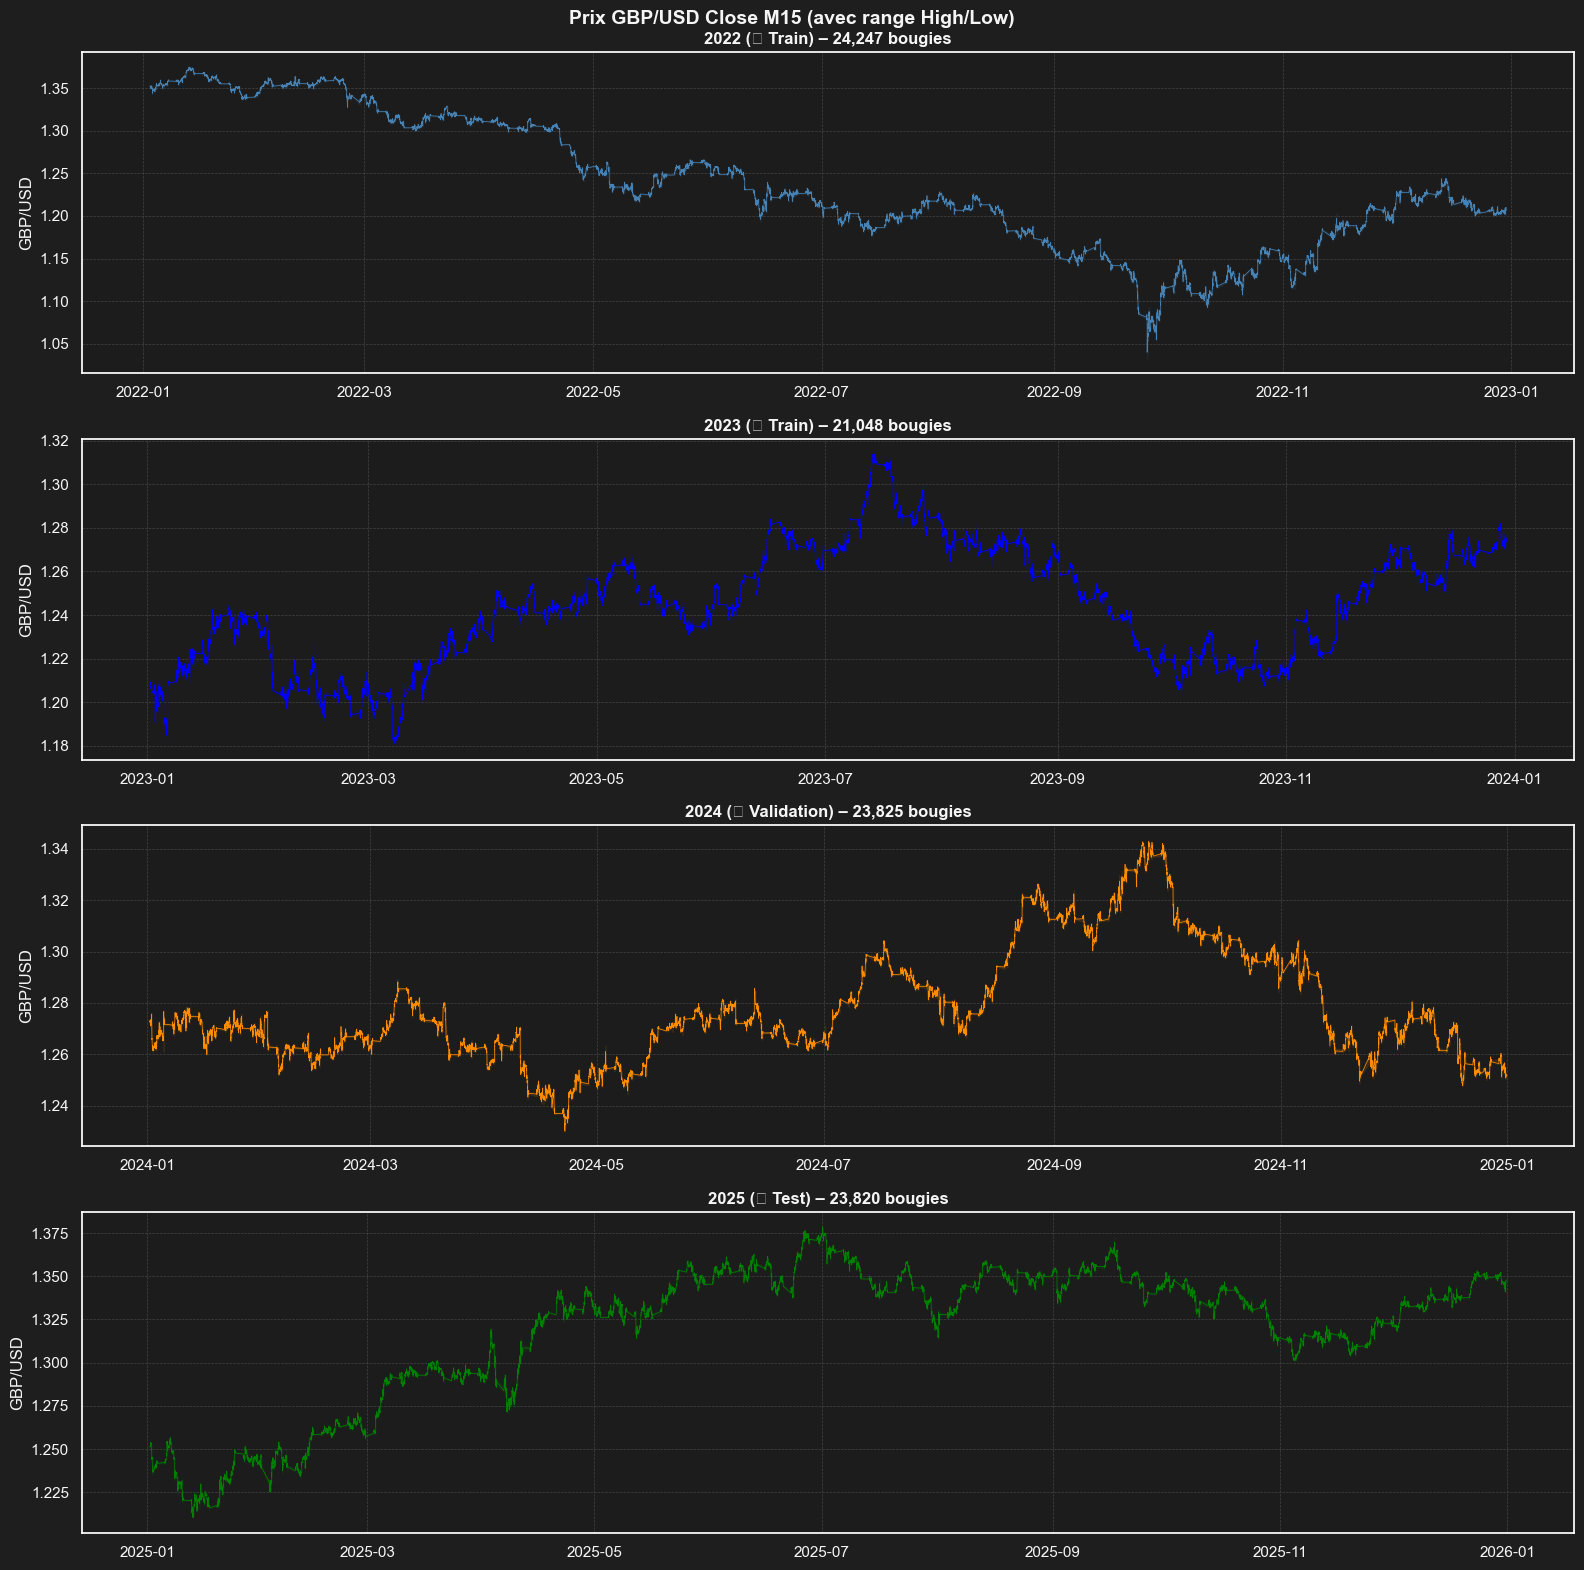

📌 2022 : Forte baisse (crise énergétique, USD haussier)
   2023 : Reprise progressive, marché latéral puis haussier
   2024 : Consolidation et volatilité modérée


In [125]:
if m15:
    n = len(m15)
    fig, axes = plt.subplots(n, 1, figsize=(16, 4 * n), sharex=False)
    if n == 1:
        axes = [axes]

    for i, (year, df) in enumerate(m15.items()):
        axes[i].plot(df.index, df['close_15m'], lw=0.5, color=COLORS[year])
        axes[i].fill_between(df.index, df['low_15m'], df['high_15m'],
                              alpha=0.1, color=COLORS[year])
        axes[i].set_title(f'{year} ({LABELS[year]}) – {len(df):,} bougies',
                           fontweight='bold')
        axes[i].set_ylabel('GBP/USD')

    plt.suptitle('Prix GBP/USD Close M15 (avec range High/Low)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print('📌 2022 : Forte baisse (crise énergétique, USD haussier)')
print('   2023 : Reprise progressive, marché latéral puis haussier')
print('   2024 : Consolidation et volatilité modérée')

---

# T03 : Nettoyage M15 & Rapport de Qualité

## 1. Contexte et Objectifs

1. **Filtrage technique** : Suppression des bougies incomplètes (`tick_count < 12`).
2. **Validation financière** : Vérification cohérence OHLC.
3. **Détection d'anomalies** : Mouvements suspects ou gaps anormaux.
4. **Rapport de Qualité** : Statistiques descriptives finales.

In [126]:
DATA_DIR_M15 = "data/m15"
CLEAN_DIR    = "data/m15/clean"
os.makedirs(CLEAN_DIR, exist_ok=True)

FILES_M15 = {
    "2022": "GBPUSD_M15_2022.csv",
    "2023": "GBPUSD_M15_2023.csv",
    "2024": "GBPUSD_M15_2024.csv",
    "2025": "GBPUSD_M15_2025.csv",
}

## 2. Chargement et Audit Initial

In [127]:
def load_and_audit_m15(year, filename):
    path = os.path.join(DATA_DIR_M15, filename)
    if not os.path.exists(path):
        print(f"[ERREUR] {filename} introuvable.")
        return None

    print(f"\n--- Audit {year} ---")
    df = pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')

    incoherent  = df[df['high_15m'] < df['low_15m']]
    # FIX : tick_count peut ne pas exister si le fichier ne la contient pas
    has_ticks   = 'tick_count' in df.columns
    low_ticks   = df[df['tick_count'] < 5] if has_ticks else pd.DataFrame()
    zeros       = (df[['open_15m','high_15m','low_15m','close_15m']] <= 0).sum().sum()

    print(f"Lignes totales                         : {len(df)}")
    print(f"Prix incohérents (High < Low)           : {len(incoherent)}")
    if has_ticks:
        print(f"Bougies incomplètes (< 5 ticks)        : {len(low_ticks)} "
              f"({len(low_ticks)/len(df):.2%})")
    else:
        print("Colonne tick_count absente – vérification ignorée.")
    print(f"Prix <= 0                               : {zeros}")

    return df

dfs_m15 = {}
for year, fname in FILES_M15.items():
    res = load_and_audit_m15(year, fname)
    if res is not None:
        dfs_m15[year] = res


--- Audit 2022 ---
Lignes totales                         : 24247
Prix incohérents (High < Low)           : 0
Bougies incomplètes (< 5 ticks)        : 0 (0.00%)
Prix <= 0                               : 0

--- Audit 2023 ---
Lignes totales                         : 21048
Prix incohérents (High < Low)           : 0
Bougies incomplètes (< 5 ticks)        : 0 (0.00%)
Prix <= 0                               : 0

--- Audit 2024 ---
Lignes totales                         : 23825
Prix incohérents (High < Low)           : 0
Bougies incomplètes (< 5 ticks)        : 0 (0.00%)
Prix <= 0                               : 0

--- Audit 2025 ---
Lignes totales                         : 23820
Prix incohérents (High < Low)           : 0
Bougies incomplètes (< 5 ticks)        : 0 (0.00%)
Prix <= 0                               : 0


## 3. Procédure de Nettoyage

**Règle** : Suppression si `tick_count < 12` (bougie construite sur moins de 80 % des minutes disponibles).

In [128]:
def clean_data_m15(df, year):
    init_len  = len(df)

    # 1. Bougies incomplètes
    if 'tick_count' in df.columns:
        df_clean = df[df['tick_count'] >= 12].copy()
    else:
        df_clean = df.copy()  # pas de filtrage si tick_count absent
    dropped_ticks = init_len - len(df_clean)

    # 2. Cohérence High / Low
    mask_ok      = df_clean['high_15m'] >= df_clean['low_15m']
    dropped_coh  = (~mask_ok).sum()
    df_clean     = df_clean[mask_ok]

    print(f"[{year}] -{dropped_ticks} (ticks faibles), -{dropped_coh} (incohérences OHLC)"
          f" → {len(df_clean)} bougies restantes")
    return df_clean

cleaned_dfs = {}
for year, df in dfs_m15.items():
    cleaned_dfs[year] = clean_data_m15(df, year)

[2022] -0 (ticks faibles), -0 (incohérences OHLC) → 24247 bougies restantes
[2023] -0 (ticks faibles), -0 (incohérences OHLC) → 21048 bougies restantes
[2024] -0 (ticks faibles), -0 (incohérences OHLC) → 23825 bougies restantes
[2025] -0 (ticks faibles), -0 (incohérences OHLC) → 23820 bougies restantes


## 4. Rapport de Qualité Final

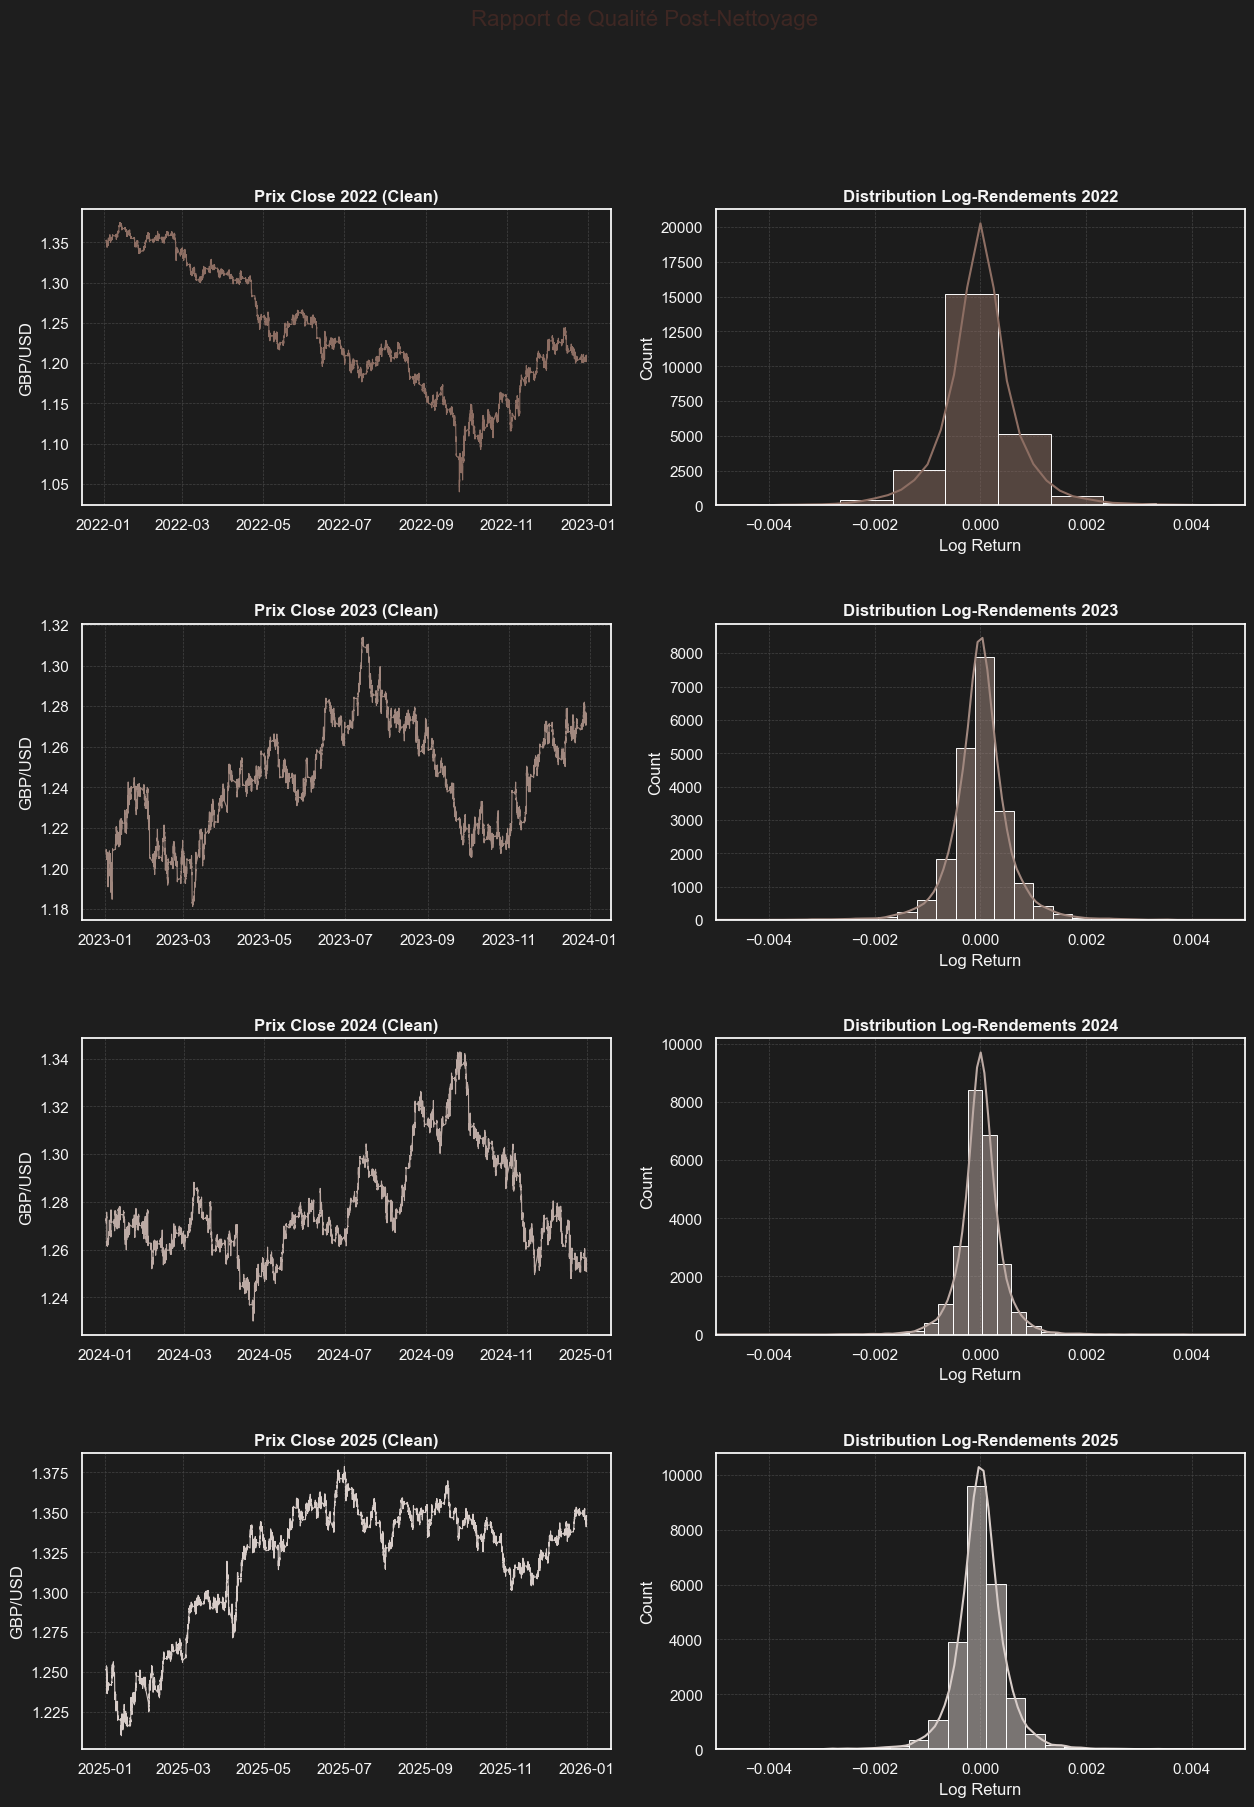

In [129]:
fig, axes = plt.subplots(len(cleaned_dfs), 2, figsize=(15, 5 * len(cleaned_dfs)))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
colors_t03 = ['#8D6E63', '#A1887F', '#BCAAA4', '#D7CCC8']

for i, (year, df) in enumerate(cleaned_dfs.items()):
    ax_p = axes[i, 0]
    ax_d = axes[i, 1]

    ax_p.plot(df.index, df['close_15m'], color=colors_t03[i], linewidth=0.8)
    ax_p.set_title(f"Prix Close {year} (Clean)", fontweight='bold')
    ax_p.set_ylabel("GBP/USD")

    log_ret = np.log(df['close_15m'] / df['close_15m'].shift(1)).dropna()
    sns.histplot(log_ret, bins=50, kde=True, ax=ax_d,
                 color=colors_t03[i], alpha=0.5)
    ax_d.set_title(f"Distribution Log-Rendements {year}", fontweight='bold')
    ax_d.set_xlabel("Log Return")
    ax_d.set_xlim(-0.005, 0.005)

plt.suptitle("Rapport de Qualité Post-Nettoyage", fontsize=16, y=0.98, color="#3E2723")
plt.show()

## 5. Sauvegarde

In [130]:
for year, df in cleaned_dfs.items():
    filename  = f"GBPUSD_M15_{year}_clean.csv"
    save_path = os.path.join(CLEAN_DIR, filename)
    df.to_csv(save_path)
    print(f"✅ Sauvegardé : {save_path}  ({len(df)} lignes)")

✅ Sauvegardé : data/m15/clean\GBPUSD_M15_2022_clean.csv  (24247 lignes)
✅ Sauvegardé : data/m15/clean\GBPUSD_M15_2023_clean.csv  (21048 lignes)
✅ Sauvegardé : data/m15/clean\GBPUSD_M15_2024_clean.csv  (23825 lignes)
✅ Sauvegardé : data/m15/clean\GBPUSD_M15_2025_clean.csv  (23820 lignes)


---

# T04 : Analyse Exploratoire (EDA) + ADF/ACF

## Objectif
Comprendre les propriétés statistiques de la série GBP/USD M15 :
- Distribution des rendements
- Évolution de la volatilité
- Patterns horaires
- Autocorrélation
- Stationnarité (test ADF)

In [131]:
# Construction du dataset complet à partir des fichiers clean
# FIX : COLORS doit être défini dans ce scope (repris de T02)
all_year_frames = []
for year in YEARS:
    path = os.path.join(CLEAN_DIR, f"GBPUSD_M15_{year}_clean.csv")
    if not os.path.exists(path):
        print(f"[SKIP] {path} introuvable")
        continue
    tmp = pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
    tmp['year'] = year
    all_year_frames.append(tmp)

if not all_year_frames:
    # fallback : utiliser cleaned_dfs si disponibles en mémoire
    all_year_frames = [df.assign(year=int(y)) for y, df in cleaned_dfs.items()]

df_all = pd.concat(all_year_frames).sort_index()
df_all['return_15m'] = df_all['close_15m'].pct_change()
df_all['log_return'] = np.log(df_all['close_15m'] / df_all['close_15m'].shift(1))
df_all['hour']       = df_all.index.hour

print(f"Dataset complet : {len(df_all):,} bougies M15")
print(f"Période : {df_all.index.min()} → {df_all.index.max()}")

Dataset complet : 92,940 bougies M15
Période : 2022-01-02 17:45:00 → 2025-12-31 16:30:00


### 4.1 Distribution des rendements

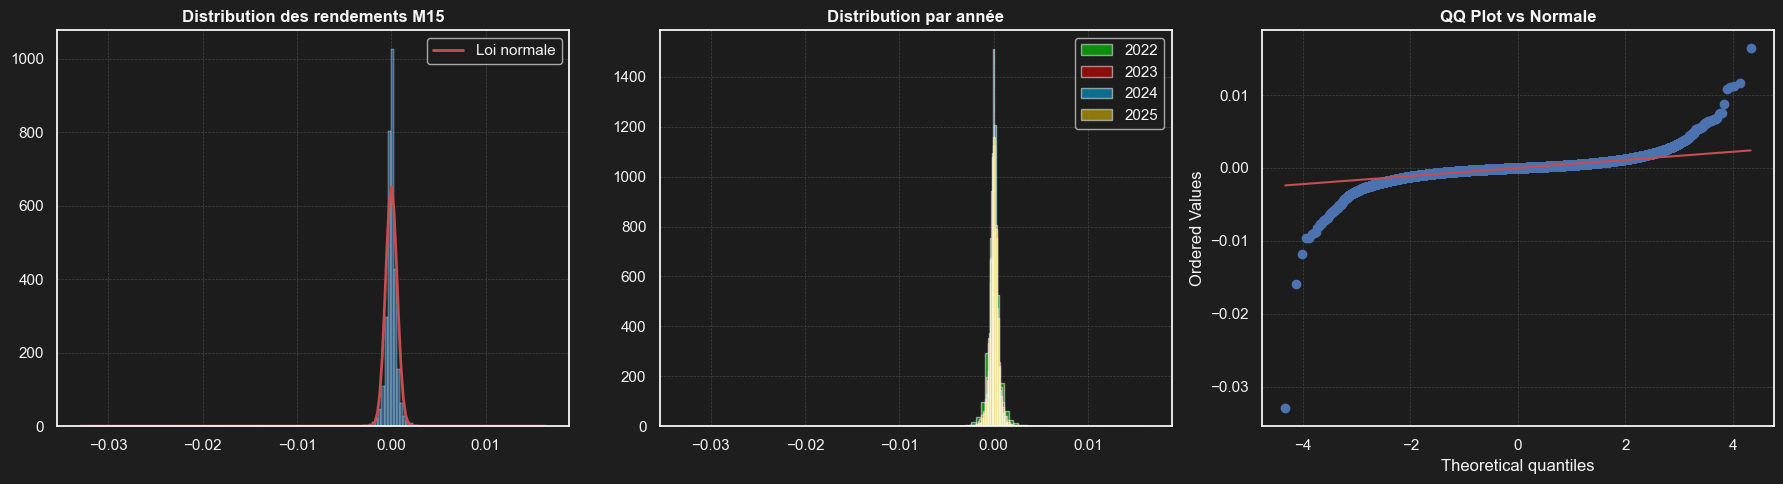

Moyenne    : 0.00000015
Écart-type : 0.000612
Skewness   : -1.5853
Kurtosis   : 124.1680  (> 0 → leptokurtique, queues épaisses)
Jarque-Bera: stat=59736786.17, p=0.00e+00  → non-normalité confirmée


In [132]:
returns = df_all['return_15m'].dropna()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogramme + loi normale
axes[0].hist(returns, bins=150, density=True, alpha=0.7,
             color='steelblue', edgecolor='white', lw=0.3)
x = np.linspace(returns.min(), returns.max(), 200)
axes[0].plot(x, sp_stats.norm.pdf(x, returns.mean(), returns.std()),
             'r-', lw=2, label='Loi normale')
axes[0].set_title('Distribution des rendements M15', fontweight='bold')
axes[0].legend()

# Par année
for year in [y for y in YEARS if y in df_all['year'].values]:
    r = df_all[df_all['year'] == year]['return_15m'].dropna()
    axes[1].hist(r, bins=100, density=True, alpha=0.5, label=str(year))
axes[1].set_title('Distribution par année', fontweight='bold')
axes[1].legend()

# QQ Plot
sp_stats.probplot(returns, dist='norm', plot=axes[2])
axes[2].set_title('QQ Plot vs Normale', fontweight='bold')

plt.tight_layout()
plt.show()

print(f'Moyenne    : {returns.mean():.8f}')
print(f'Écart-type : {returns.std():.6f}')
print(f'Skewness   : {returns.skew():.4f}')
print(f'Kurtosis   : {returns.kurtosis():.4f}  (> 0 → leptokurtique, queues épaisses)')
jb, pval = sp_stats.jarque_bera(returns)
print(f'Jarque-Bera: stat={jb:.2f}, p={pval:.2e}  → non-normalité confirmée')

### 4.2 Volatilité dans le temps

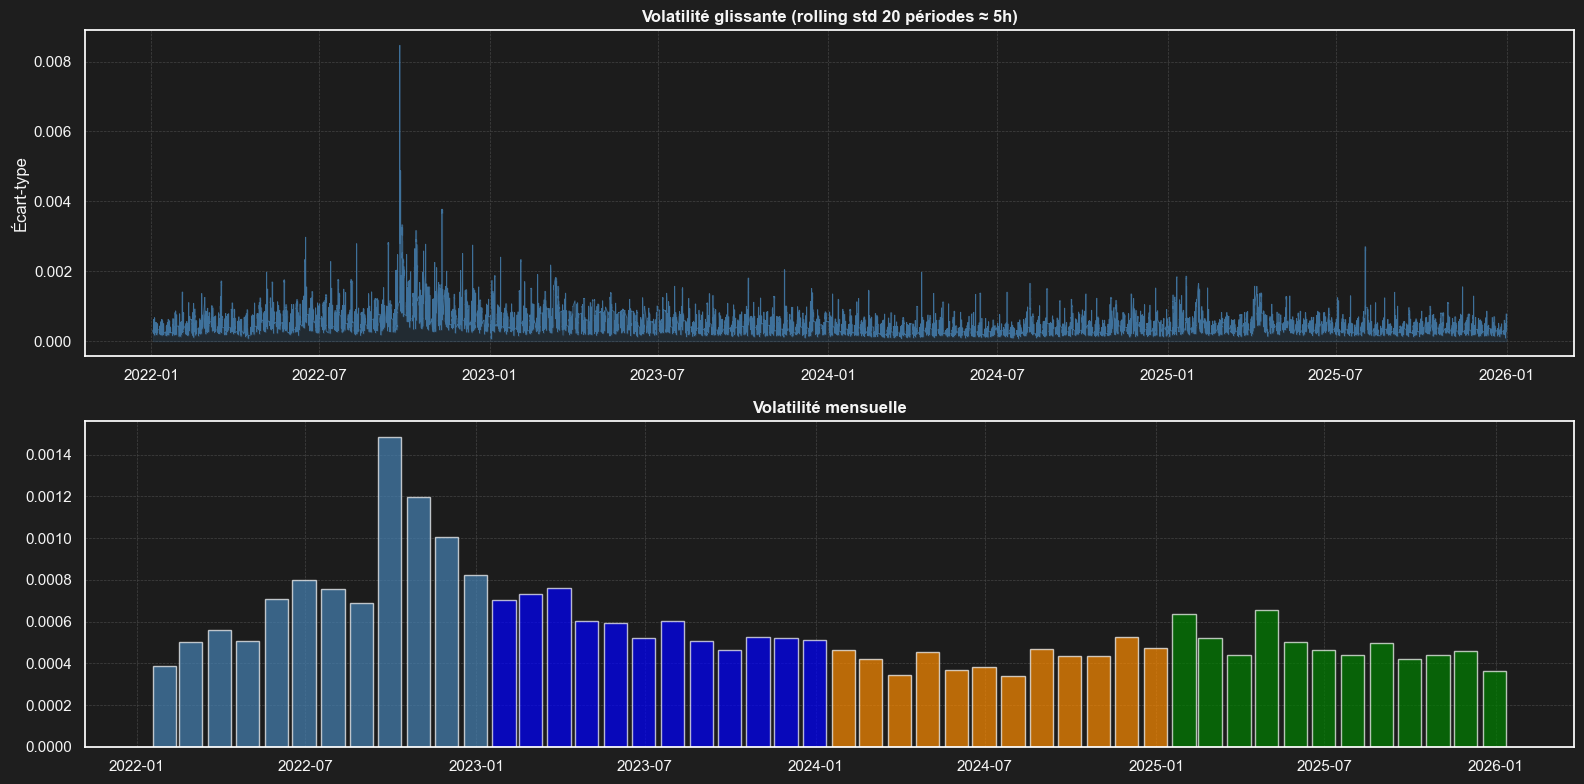

📌 Hétéroscédasticité confirmée : clustering de volatilité visible.
   → Justifie l'utilisation de features ATR et rolling_std.


In [133]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

rolling_vol = df_all['return_15m'].rolling(20).std()
axes[0].plot(df_all.index, rolling_vol, lw=0.5, color='steelblue', alpha=0.8)
axes[0].fill_between(df_all.index, 0, rolling_vol, alpha=0.15, color='steelblue')
axes[0].set_title('Volatilité glissante (rolling std 20 périodes ≈ 5h)', fontweight='bold')
axes[0].set_ylabel('Écart-type')

# FIX : resample('ME') n'existe pas dans toutes les versions de pandas.
#        'M' (Month End) est universel ; on teste les deux pour robustesse.
try:
    monthly_vol = df_all['return_15m'].resample('ME').std()
except ValueError:
    monthly_vol = df_all['return_15m'].resample('M').std()

bar_colors = [COLORS.get(d.year, 'gray') for d in monthly_vol.index]
axes[1].bar(monthly_vol.index, monthly_vol.values, width=25,
            color=bar_colors, alpha=0.7)
axes[1].set_title('Volatilité mensuelle', fontweight='bold')

plt.tight_layout()
plt.show()

print('📌 Hétéroscédasticité confirmée : clustering de volatilité visible.')
print('   → Justifie l\'utilisation de features ATR et rolling_std.')

### 4.3 Analyse horaire

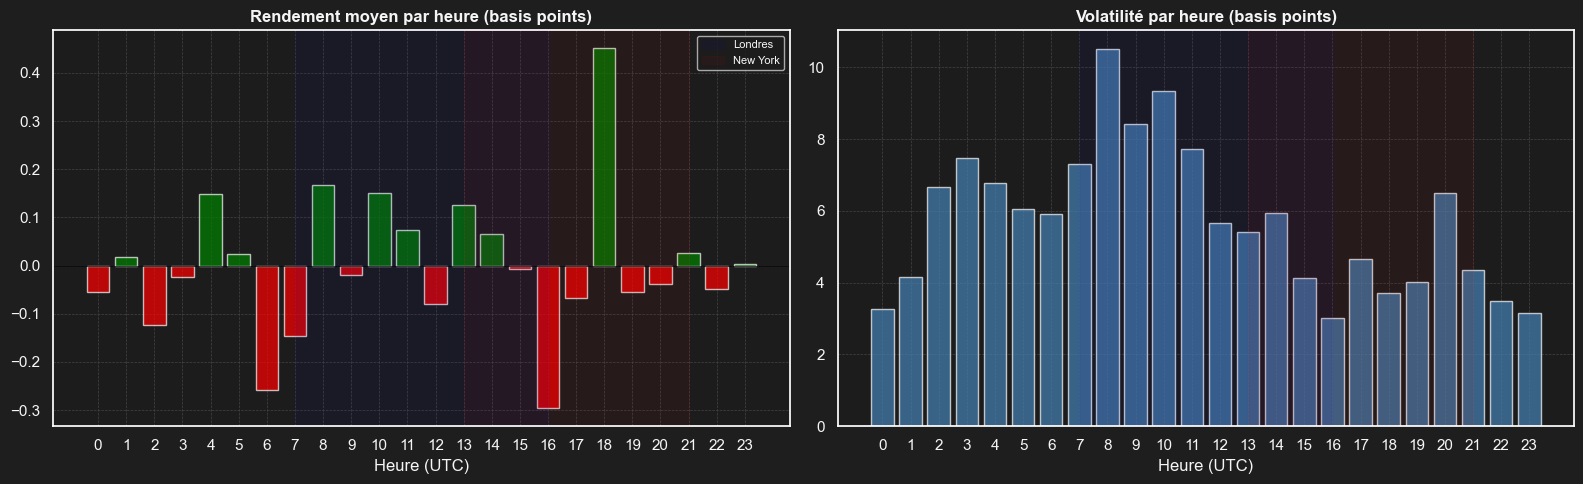

📌 Pic de volatilité au chevauchement Londres/NY (13h-16h UTC).


In [134]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

h_ret = df_all.groupby('hour')['return_15m'].mean()
h_vol = df_all.groupby('hour')['return_15m'].std()

axes[0].bar(h_ret.index, h_ret.values * 10_000,
            color=['green' if r > 0 else 'red' for r in h_ret], alpha=0.7)
axes[0].set_title('Rendement moyen par heure (basis points)', fontweight='bold')
axes[0].axhline(0, color='black', lw=0.5)

axes[1].bar(h_vol.index, h_vol.values * 10_000, color='steelblue', alpha=0.7)
axes[1].set_title('Volatilité par heure (basis points)', fontweight='bold')

for ax in axes:
    ax.axvspan(7,  16, alpha=0.05, color='blue',  label='Londres')
    ax.axvspan(13, 21, alpha=0.05, color='red',   label='New York')
    ax.set_xticks(range(24))
    ax.set_xlabel('Heure (UTC)')
axes[0].legend(fontsize=8)

plt.tight_layout()
plt.show()

print('📌 Pic de volatilité au chevauchement Londres/NY (13h-16h UTC).')

### 4.4 Autocorrélation (ACF/PACF)

In [ ]:
ret = df_all['return_15m'].dropna()
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

plot_acf(ret,      lags=50, ax=axes[0, 0], title='ACF – Rendements')
plot_pacf(ret,     lags=50, ax=axes[0, 1], title='PACF – Rendements', method='ywm')
plot_acf(ret**2,   lags=50, ax=axes[1, 0], title='ACF – Rendements² (effet ARCH)')
plot_acf(ret.abs(),lags=50, ax=axes[1, 1], title='ACF – |Rendements| (persistance vol.)')

plt.suptitle('Autocorrélation GBP/USD M15', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print('📌 Rendements bruts : quasi-imprévisibles (EMH faible).')
print('   Rendements² et |rendements| : forte autocorrélation → clustering de vol.')

### 4.5 Test ADF (Stationnarité)

In [ ]:
print('═' * 60)
print('TEST ADF – H0 : non-stationnaire | H1 : stationnaire')
print('═' * 60)

for name, s in [('Prix (close_15m)',   df_all['close_15m']),
                ('Rendements',          df_all['return_15m']),
                ('Log-rendements',      df_all['log_return'])]:
    result  = adfuller(s.dropna(), autolag='AIC')
    label   = '✅ STATIONNAIRE' if result[1] < 0.05 else '❌ NON STATIONNAIRE'
    print(f'\n📈 {name} :')
    print(f'   ADF stat : {result[0]:.4f}  |  p-value : {result[1]:.2e}  → {label}')
    for lvl, val in result[4].items():
        flag = '✅' if result[0] < val else '❌'
        print(f'   CV {lvl:>3}  : {val:.4f}  {flag}')

print('\n📌 Les PRIX ne sont pas stationnaires → on modélise les RENDEMENTS.')

════════════════════════════════════════════════════════════
TEST ADF – H0 : non-stationnaire | H1 : stationnaire
════════════════════════════════════════════════════════════

📈 Prix (close_15m) :
   ADF stat : -2.3218  |  p-value : 1.65e-01  → ❌ NON STATIONNAIRE
   CV  1%  : -3.4304  ❌
   CV  5%  : -2.8616  ❌
   CV 10%  : -2.5668  ❌

📈 Rendements :
   ADF stat : -33.8859  |  p-value : 0.00e+00  → ✅ STATIONNAIRE
   CV  1%  : -3.4304  ✅
   CV  5%  : -2.8616  ✅
   CV 10%  : -2.5668  ✅

📈 Log-rendements :
   ADF stat : -33.8647  |  p-value : 0.00e+00  → ✅ STATIONNAIRE
   CV  1%  : -3.4304  ✅
   CV  5%  : -2.8616  ✅
   CV 10%  : -2.5668  ✅

📌 Les PRIX ne sont pas stationnaires → on modélise les RENDEMENTS.


---

# T05 : Feature Engineering

## 1. Objectifs
Créer les variables explicatives pour les modèles ML/RL :
- **Bloc Court Terme** : Returns, RSI, Ranges, EMAs courtes
- **Bloc Contexte & Régime** : EMA 200, ADX, ATR, volatilité relative

In [ ]:
FEATURES_DIR = "data/features"
os.makedirs(FEATURES_DIR, exist_ok=True)

FILES_CLEAN = {
    "2022": "GBPUSD_M15_2022_clean.csv",
    "2023": "GBPUSD_M15_2023_clean.csv",
    "2024": "GBPUSD_M15_2024_clean.csv",
}

## 2. Bibliothèque d'Indicateurs Techniques

In [ ]:
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain  = delta.where(delta > 0, 0.0).ewm(alpha=1/period, adjust=False).mean()
    loss  = (-delta.where(delta < 0, 0.0)).ewm(alpha=1/period, adjust=False).mean()
    rs    = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr(df, period=14):
    h, l, c   = df['high_15m'], df['low_15m'], df['close_15m']
    prev_c    = c.shift(1)
    tr        = pd.concat([h - l, (h - prev_c).abs(), (l - prev_c).abs()], axis=1).max(axis=1)
    return tr.ewm(alpha=1/period, adjust=False).mean()

def calculate_adx(df, period=14):
    h, l      = df['high_15m'], df['low_15m']
    plus_dm   = h.diff().clip(lower=0)
    minus_dm  = (-l.diff()).clip(lower=0)
    # FIX : on met à zéro les cas où les deux DM sont positifs simultanément
    both_pos  = (h.diff() > 0) & ((-l.diff()) > 0)
    plus_dm   = plus_dm.where(h.diff() >= (-l.diff()), 0.0)
    minus_dm  = minus_dm.where((-l.diff()) > h.diff(), 0.0)

    atr       = calculate_atr(df, period)
    plus_di   = 100 * (plus_dm.ewm(alpha=1/period, adjust=False).mean() / atr)
    minus_di  = 100 * (minus_dm.ewm(alpha=1/period, adjust=False).mean() / atr)
    dx        = (abs(plus_di - minus_di) / (plus_di + minus_di + 1e-10)) * 100
    return dx.ewm(alpha=1/period, adjust=False).mean()

def calculate_macd(series, fast=12, slow=26, signal=9):
    ema_fast    = series.ewm(span=fast, adjust=False).mean()
    ema_slow    = series.ewm(span=slow, adjust=False).mean()
    macd_line   = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line, signal_line

## 3. Création du Feature Pack

In [ ]:
def generate_features(df):
    df_feat = df.copy()
    close   = df_feat['close_15m']

    # Bloc Court Terme
    df_feat['return_1']       = close.pct_change(1)
    df_feat['return_4']       = close.pct_change(4)
    df_feat['ema_20']         = close.ewm(span=20, adjust=False).mean()
    df_feat['ema_50']         = close.ewm(span=50, adjust=False).mean()
    df_feat['ema_diff']       = df_feat['ema_20'] - df_feat['ema_50']
    df_feat['rsi_14']         = calculate_rsi(close, 14)
    df_feat['rolling_std_20'] = close.rolling(20).std()
    df_feat['range_15m']      = df_feat['high_15m'] - df_feat['low_15m']
    df_feat['body']           = (df_feat['close_15m'] - df_feat['open_15m']).abs()
    df_feat['upper_wick']     = df_feat['high_15m'] - df_feat[['open_15m','close_15m']].max(axis=1)
    df_feat['lower_wick']     = df_feat[['open_15m','close_15m']].min(axis=1) - df_feat['low_15m']

    # Bloc Contexte & Régime
    df_feat['ema_200']            = close.ewm(span=200, adjust=False).mean()
    df_feat['distance_to_ema200'] = close - df_feat['ema_200']
    df_feat['slope_ema50']        = df_feat['ema_50'].diff(3)
    df_feat['atr_14']             = calculate_atr(df_feat, 14)
    df_feat['rolling_std_100']    = close.rolling(100).std()
    df_feat['volatility_ratio']   = df_feat['rolling_std_20'] / df_feat['rolling_std_100']
    df_feat['adx_14']             = calculate_adx(df_feat, 14)
    df_feat['macd'], df_feat['macd_signal'] = calculate_macd(close)

    df_feat.dropna(inplace=True)
    return df_feat

## 4. Application et Sauvegarde

In [ ]:
feature_sets = {}

for year, filename in FILES_CLEAN.items():
    input_path = os.path.join(CLEAN_DIR, filename)
    if not os.path.exists(input_path):
        print(f"[SKIP] {input_path} introuvable")
        continue

    print(f"Traitement {year}...")
    df_raw      = pd.read_csv(input_path, parse_dates=['timestamp'], index_col='timestamp')
    df_features = generate_features(df_raw)
    feature_sets[year] = df_features

    output_path = os.path.join(FEATURES_DIR, f"GBPUSD_M15_{year}_features.csv")
    df_features.to_csv(output_path)
    print(f"  → {df_features.shape[1]} colonnes | sauvegardé : {output_path}")

Traitement 2022...
  → 26 colonnes | sauvegardé : data/features\GBPUSD_M15_2022_features.csv
Traitement 2023...
  → 26 colonnes | sauvegardé : data/features\GBPUSD_M15_2023_features.csv
Traitement 2024...
  → 26 colonnes | sauvegardé : data/features\GBPUSD_M15_2024_features.csv


## 5. Visualisation des Régimes

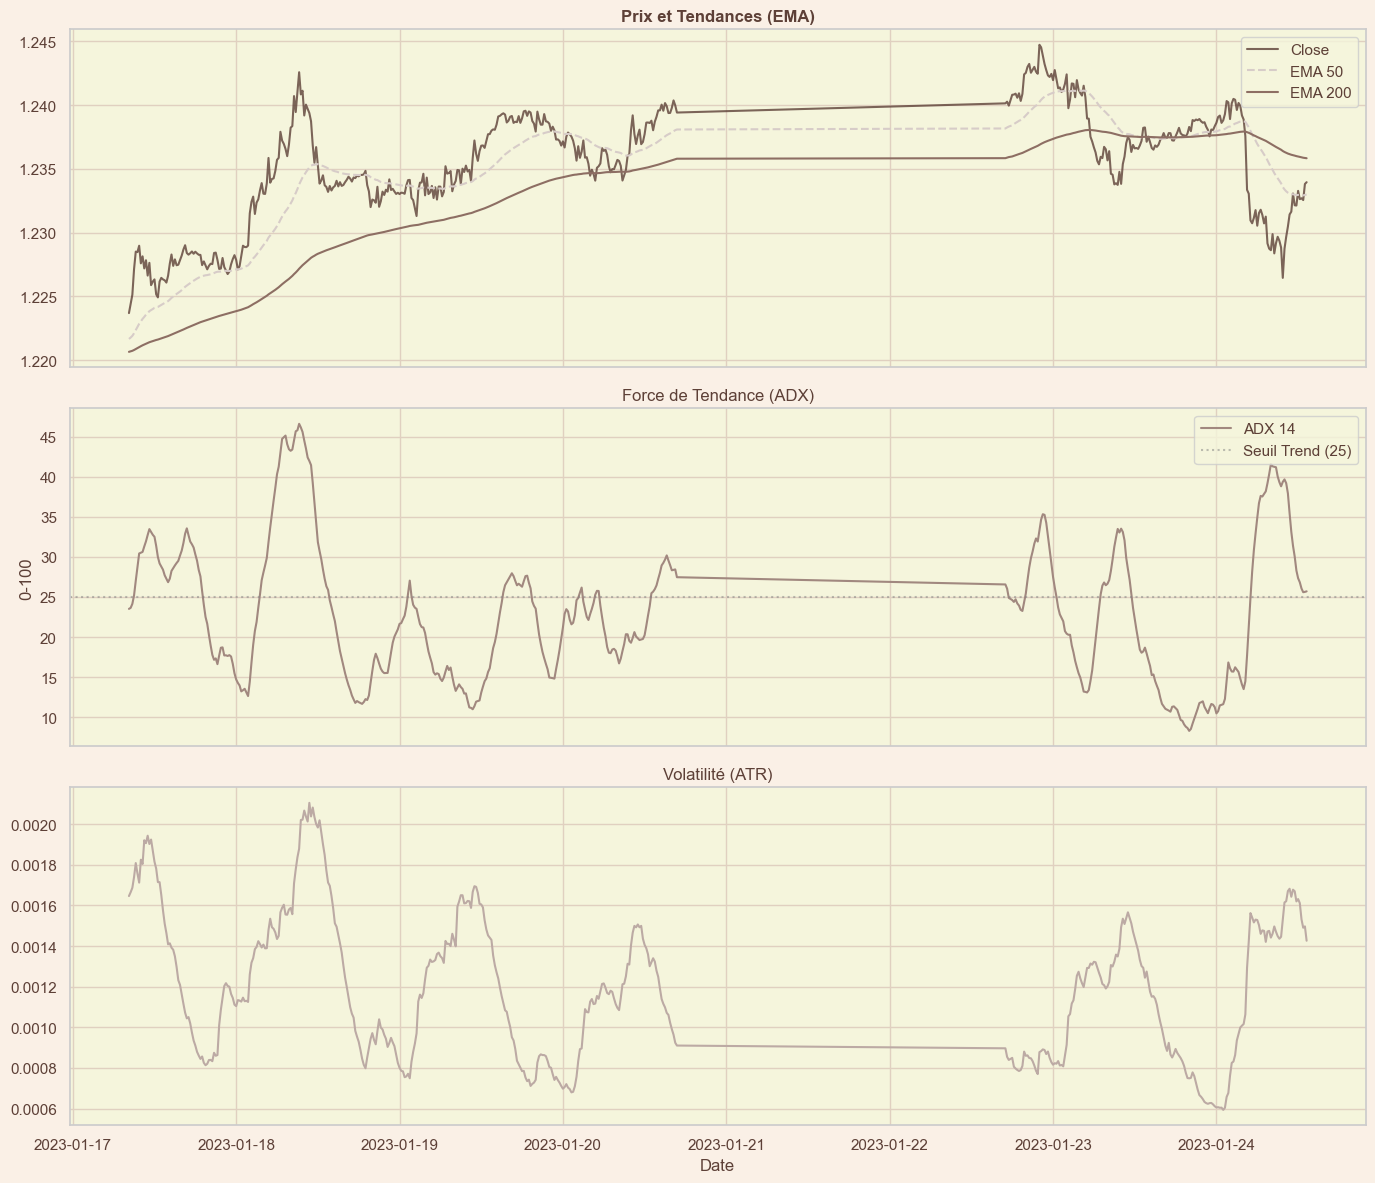

In [ ]:
target_year = next((y for y in ['2023', '2022', '2024'] if y in feature_sets), None)

if target_year:
    sample = feature_sets[target_year].iloc[1000:1500]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    ax1.plot(sample.index, sample['close_15m'],  label='Close', color='#5D4037', alpha=0.8)
    ax1.plot(sample.index, sample['ema_50'],     label='EMA 50', color='#D7CCC8', ls='--')
    ax1.plot(sample.index, sample['ema_200'],    label='EMA 200', color='#8D6E63', lw=1.5)
    ax1.set_title("Prix et Tendances (EMA)", fontweight='bold')
    ax1.legend()

    ax2.plot(sample.index, sample['adx_14'], label='ADX 14', color='#A1887F')
    ax2.axhline(25, color='gray', ls=':', alpha=0.5, label='Seuil Trend (25)')
    ax2.set_title("Force de Tendance (ADX)")
    ax2.set_ylabel("0-100")
    ax2.legend()

    ax3.plot(sample.index, sample['atr_14'], label='ATR 14', color='#BCAAA4')
    ax3.set_title("Volatilité (ATR)")
    ax3.set_xlabel("Date")

    plt.tight_layout()
    plt.show()
else:
    print("[INFO] Aucune donnée feature disponible pour la visualisation.")

---

# T06 : Baselines & Backtest

## Objectif
Établir des **références de performance** avant tout ML/RL :
- **Random** : référence "aucune intelligence"
- **Buy & Hold** : référence "marché passif"
- **EMA + RSI** : référence "analyse technique classique"

> Un modèle ML/RL n'est utile QUE s'il bat ces baselines de manière robuste.

In [ ]:
# ─── FIX : Backtester implémenté inline (pas de module externe requis) ───
class Backtester:
    """Backtester vectorisé simple. transaction_cost exprimé en fraction de prix."""
    def __init__(self, transaction_cost=0.0002):
        self.tc = transaction_cost

    def run(self, prices: pd.Series, signals: pd.Series) -> dict:
        """
        prices  : série de prix close
        signals : +1 (long), -1 (short), 0 (flat)
        """
        prices  = prices.reset_index(drop=True)
        signals = signals.reset_index(drop=True).astype(int)

        # Rendements bruts de la période
        price_ret = prices.pct_change().fillna(0)

        # Coût à chaque changement de position
        position_change = signals.diff().abs().fillna(0)
        cost            = position_change * self.tc

        # Rendements de la stratégie
        strat_ret   = signals.shift(1).fillna(0) * price_ret - cost
        equity_arr  = (1 + strat_ret).cumprod().values * 100

        # Métriques
        total_ret   = equity_arr[-1] / equity_arr[0] - 1
        peak        = np.maximum.accumulate(equity_arr)
        dd          = (equity_arr - peak) / peak
        max_dd      = dd.min()
        ann_factor  = np.sqrt(252 * 96)          # 96 bougies M15 / jour
        sharpe      = (strat_ret.mean() / (strat_ret.std() + 1e-10)) * ann_factor

        trades       = position_change[position_change > 0]
        nb_trades    = int(trades.sum())
        wins         = (strat_ret[signals.shift(1) != 0] > 0)
        win_rate     = wins.mean() * 100 if len(wins) else 0.0
        gross_profit = strat_ret[strat_ret > 0].sum()
        gross_loss   = abs(strat_ret[strat_ret < 0].sum())
        pf           = gross_profit / gross_loss if gross_loss > 1e-10 else np.inf

        return {
            'equity_curve': equity_arr,
            'metrics': {
                'profit_cumule_pct': total_ret * 100,
                'max_drawdown_pct':  max_dd * 100,
                'sharpe':            sharpe,
                'profit_factor':     pf,
                'win_rate':          win_rate,
                'nb_trades':         nb_trades,
            }
        }

bt = Backtester(transaction_cost=0.0002)
print("✅ Backtester initialisé (2 pips de coût)")

✅ Backtester initialisé (2 pips de coût)


In [ ]:
def add_indicators_t06(df):
    df       = df.copy()
    close    = df['close_15m']
    df['ema_20'] = close.ewm(span=20, adjust=False).mean()
    df['ema_50'] = close.ewm(span=50, adjust=False).mean()
    delta        = close.diff()
    gain         = delta.where(delta > 0, 0.0).rolling(14).mean()
    loss         = (-delta.where(delta < 0, 0.0)).rolling(14).mean()
    df['rsi_14'] = 100 - (100 / (1 + gain / (loss + 1e-10)))
    return df

def strategy_ema_rsi(df):
    """BUY si EMA20 > EMA50 et RSI < 70 ; SELL si EMA20 < EMA50 et RSI > 30."""
    signals = np.zeros(len(df), dtype=int)
    e20, e50, rsi = df['ema_20'].values, df['ema_50'].values, df['rsi_14'].values
    for i in range(1, len(df)):
        if np.isnan(e20[i]) or np.isnan(e50[i]) or np.isnan(rsi[i]):
            continue
        if   e20[i] > e50[i] and rsi[i] < 70:  signals[i] =  1
        elif e20[i] < e50[i] and rsi[i] > 30:  signals[i] = -1
    return pd.Series(signals)

In [ ]:
# Exécution sur les données m15 disponibles
# FIX : on utilise cleaned_dfs si m15 n'est pas peuplé
data_source = m15 if m15 else {str(y): df for y, df in cleaned_dfs.items()}

all_results = {}
rng = np.random.RandomState(42)

for key, df_raw in data_source.items():
    year_int = int(key) if isinstance(key, str) else key
    if year_int not in YEARS:
        continue
    df_ind = add_indicators_t06(df_raw)
    n      = len(df_ind)
    all_results[year_int] = {
        'Random':     bt.run(df_ind['close_15m'],
                             pd.Series(rng.choice([1, -1, 0], size=n))),
        'Buy & Hold': bt.run(df_ind['close_15m'],
                             pd.Series(np.concatenate([[1], np.zeros(n-1, dtype=int)]))),
        'EMA + RSI':  bt.run(df_ind['close_15m'], strategy_ema_rsi(df_ind)),
    }

print('✅ Baselines calculées pour :', list(all_results.keys()))

✅ Baselines calculées pour : [2022, 2023, 2024]


### 6.1 Equity curves

C:\Users\JC\AppData\Local\Temp\ipykernel_29352\3655850777.py:19: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\JC\AppData\Local\Temp\ipykernel_29352\3655850777.py:19: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\JC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128999 (\N{LARGE ORANGE SQUARE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


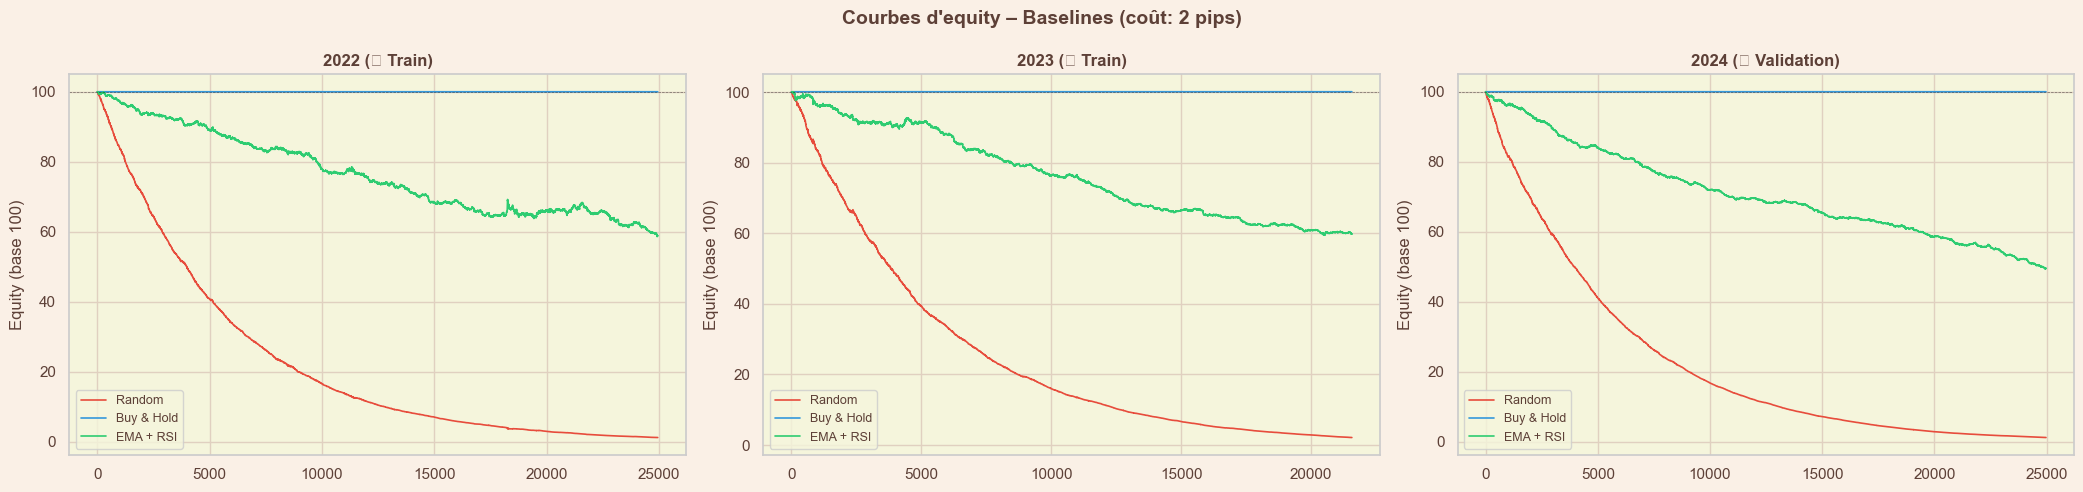

In [ ]:
strat_colors = {'Random': '#e74c3c', 'Buy & Hold': '#3498db', 'EMA + RSI': '#2ecc71'}
years_bt     = sorted(all_results.keys())

fig, axes = plt.subplots(1, max(len(years_bt), 1), figsize=(7 * len(years_bt), 5))
if len(years_bt) == 1:
    axes = [axes]

for i, year in enumerate(years_bt):
    for name, res in all_results[year].items():
        eq = res['equity_curve']
        axes[i].plot(eq, lw=1.2, label=name, color=strat_colors[name])
    axes[i].axhline(100, color='black', lw=0.5, ls='--', alpha=0.5)
    axes[i].set_title(f'{year} ({LABELS.get(year, "")})', fontweight='bold')
    axes[i].set_ylabel('Equity (base 100)')
    axes[i].legend(fontsize=9)

plt.suptitle("Courbes d'equity – Baselines (coût: 2 pips)",
             fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

### 6.2 Tableau récapitulatif

In [ ]:
rows = []
for year in years_bt:
    for name, res in all_results[year].items():
        m = res['metrics']
        rows.append({
            'Année':        year,
            'Période':      LABELS.get(year, ''),
            'Stratégie':    name,
            'Profit (%)':   round(m['profit_cumule_pct'], 2),
            'Max DD (%)':   round(m['max_drawdown_pct'],  2),
            'Sharpe':       round(m['sharpe'],            3),
            'Profit Factor':round(m['profit_factor'],     3),
            'Win Rate (%)': round(m['win_rate'],          1),
            'Trades':       m['nb_trades'],
        })

df_summary = pd.DataFrame(rows)
display(df_summary)

print('\n📌 Un modèle ML/RL doit battre ces 3 baselines de façon CONSISTANTE sur 2023 ET 2024.')

,Année,Période,Stratégie,Profit (%),Max DD (%),Sharpe,Profit Factor,Win Rate (%),Trades
0,2022,🟦 Train,Random,-98.79,-98.79,-38.184,0.411,34.5,22169
1,2022,🟦 Train,Buy & Hold,-0.01,-0.01,-0.985,0.000,0.0,1
2,2022,🟦 Train,EMA + RSI,-41.10,-41.40,-4.373,0.903,48.3,3021
3,2023,🟦 Train,Random,-97.86,-97.86,-55.374,0.312,31.1,19090
4,2023,🟦 Train,Buy & Hold,0.09,0.00,1.059,inf,50.0,1
5,2023,🟦 Train,EMA + RSI,-40.24,-40.58,-7.032,0.859,48.1,2687
6,2024,🟧 Validation,Random,-98.76,-98.76,-72.923,0.233,28.2,22048
7,2024,🟧 Validation,Buy & Hold,0.01,0.00,0.984,inf,50.0,1
8,2024,🟧 Validation,EMA + RSI,-50.45,-50.60,-11.619,0.779,46.5,2951



📌 Un modèle ML/RL doit battre ces 3 baselines de façon CONSISTANTE sur 2023 ET 2024.


---

# T07 : Machine Learning & Évaluation

## 1. Contexte et Objectifs

Entraîner des modèles supervisés pour prédire la direction M15 suivante.
- **Train 2022** | **Validation 2023** | **Test 2024** (sanctuarisé)
- Cible binaire : `1` si Close[t+1] > Close[t], sinon `0`

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

MODELS_DIR = "models/v1"
os.makedirs(MODELS_DIR, exist_ok=True)

print("Imports sklearn OK")

Imports sklearn OK


## 2. Préparation des Données

In [ ]:
def load_and_prep_features(year_str):
    path = os.path.join(FEATURES_DIR, f"GBPUSD_M15_{year_str}_features.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable: {path}")
    df = pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
    df['target_return'] = df['close_15m'].shift(-1) - df['close_15m']
    df['target']        = (df['target_return'] > 0).astype(int)
    df.dropna(inplace=True)
    return df

try:
    df_train = load_and_prep_features("2022")
    df_val   = load_and_prep_features("2023")
    df_test  = load_and_prep_features("2024")
    print(f"Train : {df_train.shape} | Val : {df_val.shape} | Test : {df_test.shape}")
except FileNotFoundError as e:
    print(f"[ERREUR] {e}")
    print("Génération du feature set en mémoire depuis cleaned_dfs...")
    df_train = generate_features(cleaned_dfs.get('2022', pd.DataFrame()))
    df_val   = generate_features(cleaned_dfs.get('2023', pd.DataFrame()))
    df_test  = generate_features(cleaned_dfs.get('2024', pd.DataFrame()))
    for df in [df_train, df_val, df_test]:
        if not df.empty:
            df['target_return'] = df['close_15m'].shift(-1) - df['close_15m']
            df['target']        = (df['target_return'] > 0).astype(int)
            df.dropna(inplace=True)

Train : (24695, 28) | Val : (21385, 28) | Test : (24686, 28)


In [ ]:
# FIX : 'volume_15m' renommé en 'volume' dans les fichiers M15 bruts.
#        On drop les colonnes existantes plus prudemment.
base_ohlcv = ['open_15m', 'high_15m', 'low_15m', 'close_15m',
              'volume', 'volume_15m', 'tick_count',   # les deux noms possibles
              'target', 'target_return']

features_cols = [c for c in df_train.columns if c not in base_ohlcv]
print(f"Features ({len(features_cols)}) : {features_cols}")

def make_xy(df):
    available = [c for c in features_cols if c in df.columns]
    return df[available], df['target']

X_train, y_train = make_xy(df_train)
X_val,   y_val   = make_xy(df_val)
X_test,  y_test  = make_xy(df_test)

# Normalisation (fitté sur le TRAIN uniquement)
scaler          = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_val_scaled    = scaler.transform(X_val)
X_test_scaled   = scaler.transform(X_test)

Features (20) : ['return_1', 'return_4', 'ema_20', 'ema_50', 'ema_diff', 'rsi_14', 'rolling_std_20', 'range_15m', 'body', 'upper_wick', 'lower_wick', 'ema_200', 'distance_to_ema200', 'slope_ema50', 'atr_14', 'rolling_std_100', 'volatility_ratio', 'adx_14', 'macd', 'macd_signal']


## 3. Modélisation

In [ ]:
models_t07 = {
    "Logistic Regression": LogisticRegression(
        random_state=42, class_weight='balanced', max_iter=1000),
    "Random Forest":       RandomForestClassifier(
        n_estimators=100, max_depth=5, random_state=42, class_weight='balanced'),
}

results_t07 = {}
for name, model in models_t07.items():
    print(f"\n--- Entraînement : {name} ---")
    model.fit(X_train_scaled, y_train)
    acc_train = accuracy_score(y_train, model.predict(X_train_scaled))
    acc_val   = accuracy_score(y_val,   model.predict(X_val_scaled))
    print(f"Accuracy Train : {acc_train:.4f}  |  Accuracy Val : {acc_val:.4f}")
    print(classification_report(y_val, model.predict(X_val_scaled)))
    results_t07[name] = model


--- Entraînement : Logistic Regression ---
Accuracy Train : 0.5236  |  Accuracy Val : 0.5164
              precision    recall  f1-score   support

           0       0.52      0.59      0.55     10753
           1       0.52      0.44      0.48     10632

    accuracy                           0.52     21385
   macro avg       0.52      0.52      0.51     21385
weighted avg       0.52      0.52      0.51     21385


--- Entraînement : Random Forest ---
Accuracy Train : 0.5694  |  Accuracy Val : 0.5142
              precision    recall  f1-score   support

           0       0.52      0.57      0.54     10753
           1       0.51      0.46      0.48     10632

    accuracy                           0.51     21385
   macro avg       0.51      0.51      0.51     21385
weighted avg       0.51      0.51      0.51     21385



## 4. Évaluation Financière sur le Test Set (2024)

=== ÉVALUATION FINALE – TEST 2024 ===


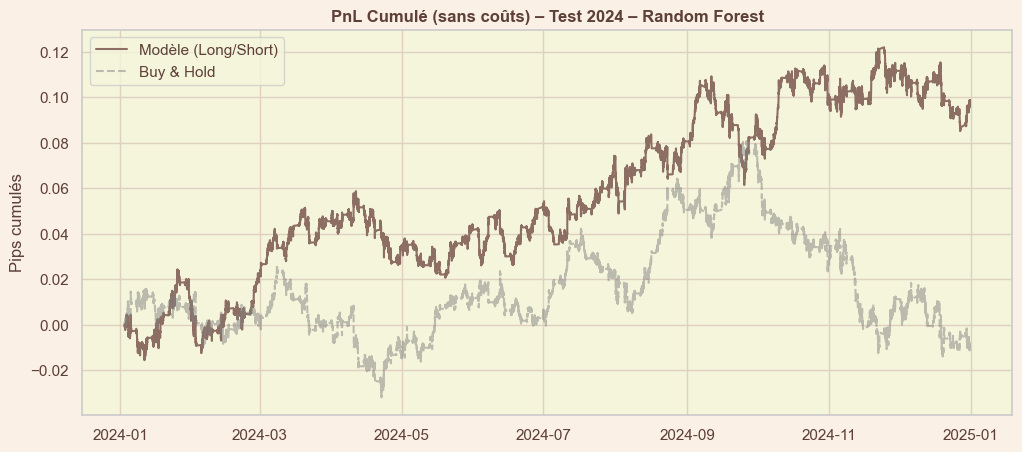

Profit Final (Pips cumulés, sans coûts) : 0.09818

⚠️  Ce résultat est brut. Ajouter les coûts (spread ~2 pips) pour un chiffre réaliste.


In [ ]:
def backtest_model_t07(model, X_scaled, df_src, title=""):
    preds    = model.predict(X_scaled)
    signals  = np.where(preds == 1, 1, -1)

    # Rendements de la stratégie (Long/Short)
    strat_ret  = pd.Series(signals, index=df_src.index) * df_src['target_return']
    cum_strat  = strat_ret.cumsum()
    cum_market = df_src['target_return'].cumsum()

    plt.figure(figsize=(12, 5))
    plt.plot(df_src.index, cum_strat,  label='Modèle (Long/Short)', color='#8D6E63')
    plt.plot(df_src.index, cum_market, label='Buy & Hold',
             color='gray', alpha=0.5, ls='--')
    plt.title(f"PnL Cumulé (sans coûts) – {title}", fontweight='bold')
    plt.ylabel("Pips cumulés")
    plt.legend()
    plt.show()

    return cum_strat.iloc[-1]

print("=== ÉVALUATION FINALE – TEST 2024 ===")
best_model = results_t07['Random Forest']
final_pnl  = backtest_model_t07(best_model, X_test_scaled, df_test,
                                 title="Test 2024 – Random Forest")
print(f"Profit Final (Pips cumulés, sans coûts) : {final_pnl:.5f}")
print("\n⚠️  Ce résultat est brut. Ajouter les coûts (spread ~2 pips) pour un chiffre réaliste.")

## 5. Importance des Features

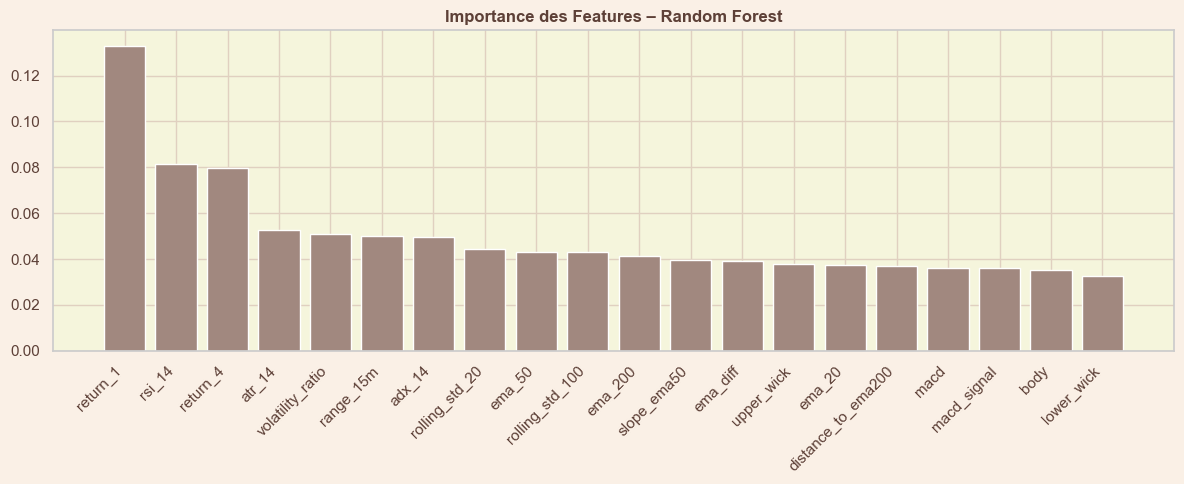

In [ ]:
importances = best_model.feature_importances_
indices     = np.argsort(importances)[::-1]
labels      = [X_train.columns[i] for i in indices]

plt.figure(figsize=(12, 5))
plt.title("Importance des Features – Random Forest", fontweight='bold')
plt.bar(range(len(indices)), importances[indices],
        align="center", color='#A1887F')
plt.xticks(range(len(indices)), labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Conclusion T07

**Points Clés :**
- Split temporel respecté (train/val/test = 2022/2023/2024).
- Normalisation ancrée sur le Train set.
- Évaluation financière brute sur 2024.

**Limitations :**
- Les coûts de transaction (spread) ne sont pas inclus dans le backtest vectorisé → résultats optimistes.
- Le modèle reste standard ; un réglage d'hyperparamètres (GridSearchCV en `TimeSeriesSplit`) est conseillé.

**Prochaine étape (T08 – RL)** : le Reinforcement Learning intégrera les coûts nativement dans la fonction de récompense et gérera mieux la séquence de décision.